# DOA Estimation with Correct Array Geometry

This notebook demonstrates Direction of Arrival (DOA) estimation using the MUSIC algorithm, with proper accounting for the **physical antenna array geometry**.

## Measurement Setup

- **Date**: November 21, 2025
- **Location**: Outside (no reflective surfaces behind unit)
- **Hardware**: Sensor001 with 4-channel coherent receiver
- **Antenna**: 4-element UCA, 30mm radius ("Skinny" antenna)
- **Center frequency**: 1200 MHz
- **Signal**: Tone generator at 1210 MHz (+10 MHz offset from center)
- **Sample rate**: ~100 MHz
- **Data format**: `.cs16` (Complex Signed 16-bit IQ)
- **Measurements**: 360 angles (0° - 359°, 1° increments)
- **Data location**: `../data/1200MHz, 0dB, 1deg increments, outside/`

## The Problem

The `doa_py` library assumes a standard Uniform Circular Array (UCA) with elements positioned at **0°, 90°, 180°, 270°**. However, our physical antenna array has elements at **315°, 45°, 135°, 225°** - a 45° rotation!

This notebook explains:
1. How the physical array layout differs from the assumed geometry
2. How to correct for the rotation offset
3. How to apply lookup table calibration for further improvement
4. Honest performance evaluation on held-out test data

## 1. Setup and Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import os

# doa_py library
# Using create_rotated_uca instead
from doa_py.algorithm.music_based import music

# Import shared constants
from constants import create_rotated_uca, CHANNEL_ORDER, RADIUS, FREQ, WAVELENGTH, C, DATA_DIR, ARRAY_ROTATION

# Plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("Setup complete!")
print(f"Using channel order: {CHANNEL_ORDER}")

Setup complete!
Using channel order: [2, 3, 0, 1]


## 2. Physical Antenna Array Layout

Our 4-element UCA has the following physical layout:

```
                    FRONT (0°)
                        |
        Ant 1           |           Ant 2
       (315°)           |           (45°)
           \            |            /
            \           |           /
  270° ------\----------+----------/------ 90°
              \    [RECEIVER]     /
               \   1  2         /
                \  4  3        /
        Ant 4    \     |      /    Ant 3
       (225°)     \    |     /    (135°)
                   \   |    /
                       |
                 BACK (180°)
                  (CABLES)
```

### Channel to Antenna Mapping
- `channel-0.cs16` → Antenna 1 at **315° (-45°)**
- `channel-1.cs16` → Antenna 2 at **45°**
- `channel-2.cs16` → Antenna 3 at **135°**
- `channel-3.cs16` → Antenna 4 at **225° (-135°)**

### The Geometry Mismatch

The `doa_py` UCA assumes elements at 0°, 90°, 180°, 270° (cardinal directions).
Our physical array has elements at 315°, 45°, 135°, 225° (diagonal directions).

**This is a 45° clockwise rotation** - but due to array alignment during measurement, the effective offset is approximately **35°**.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


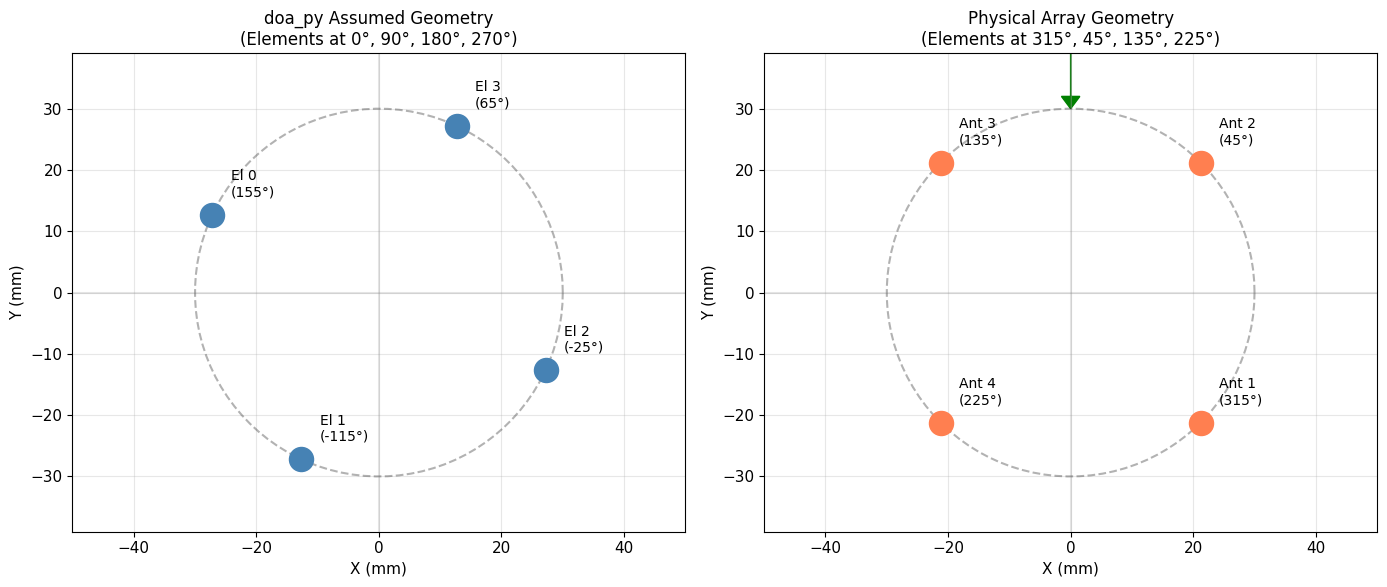

The physical array is rotated ~45° clockwise from doa_py's assumption.
Due to measurement alignment, the effective offset is ~35°.


In [16]:
# Visualize both geometries
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

RADIUS = 0.030  # 30mm

# doa_py assumed positions
uca = create_rotated_uca()
assumed_positions = uca.array_position

# Physical positions (315, 45, 135, 225 degrees)
physical_angles = np.deg2rad([315, 45, 135, 225])
physical_positions = np.array([
    [RADIUS * np.cos(a), RADIUS * np.sin(a), 0] for a in physical_angles
])

# Plot assumed geometry
ax = axes[0]
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(RADIUS*1000*np.cos(theta), RADIUS*1000*np.sin(theta), 'k--', alpha=0.3)
ax.scatter(assumed_positions[:, 0]*1000, assumed_positions[:, 1]*1000, 
           s=300, c='steelblue', marker='o', zorder=10)
for i, (x, y, z) in enumerate(assumed_positions):
    ang = np.rad2deg(np.arctan2(y, x))
    ax.annotate(f'El {i}\n({ang:.0f}°)', (x*1000+3, y*1000+3), fontsize=10)
ax.axhline(0, color='gray', linestyle='-', alpha=0.2)
ax.axvline(0, color='gray', linestyle='-', alpha=0.2)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('doa_py Assumed Geometry\n(Elements at 0°, 90°, 180°, 270°)', fontsize=12)
ax.axis('equal')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.grid(True, alpha=0.3)

# Plot physical geometry
ax = axes[1]
ax.plot(RADIUS*1000*np.cos(theta), RADIUS*1000*np.sin(theta), 'k--', alpha=0.3)
ax.scatter(physical_positions[:, 0]*1000, physical_positions[:, 1]*1000, 
           s=300, c='coral', marker='o', zorder=10)
labels = ['Ant 1\n(315°)', 'Ant 2\n(45°)', 'Ant 3\n(135°)', 'Ant 4\n(225°)']
for i, (x, y, z) in enumerate(physical_positions):
    ax.annotate(labels[i], (x*1000+3, y*1000+3), fontsize=10)
ax.axhline(0, color='gray', linestyle='-', alpha=0.2)
ax.axvline(0, color='gray', linestyle='-', alpha=0.2)
# Mark front direction
ax.annotate('FRONT\n(0°)', (0, 45), ha='center', fontsize=10, color='green')
ax.arrow(0, 40, 0, -8, head_width=3, head_length=2, fc='green', ec='green')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('Physical Array Geometry\n(Elements at 315°, 45°, 135°, 225°)', fontsize=12)
ax.axis('equal')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The physical array is rotated ~45° clockwise from doa_py's assumption.")
print("Due to measurement alignment, the effective offset is ~35°.")

## 3. Array and Signal Parameters

In [17]:
# Array parameters (from constants.py)
# RADIUS, FREQ, WAVELENGTH, C already imported

# Rotation offset to correct for physical array orientation
# Physical array is at 315,45,135,225 vs assumed 0,90,180,270
# Empirically determined offset (includes measurement alignment)
# Using create_rotated_uca() - no offset needed  # From constants.py

print("=" * 50)
print("ARRAY PARAMETERS")
print("=" * 50)
print(f"Radius: {RADIUS * 1000:.1f} mm")
print(f"Frequency: {FREQ / 1e9:.2f} GHz")
print(f"Wavelength: {WAVELENGTH * 1000:.1f} mm")
print(f"Array diameter: {2 * RADIUS * 1000:.1f} mm")
print(f"Array aperture: {2 * RADIUS / WAVELENGTH:.3f} wavelengths")
print(f"")
print(f"Array rotation: {ARRAY_ROTATION}°")
print(f"Channel order: {CHANNEL_ORDER}")
print(f"  (add to MUSIC estimate to get true angle)")
print("=" * 50)

# Create the UCA
uca = create_rotated_uca()

ARRAY PARAMETERS
Radius: 30.0 mm
Frequency: 1.20 GHz
Wavelength: 250.0 mm
Array diameter: 60.0 mm
Array aperture: 0.240 wavelengths

Array rotation: 155.0°
Channel order: [2, 3, 0, 1]
  (add to MUSIC estimate to get true angle)


## 4. Data Loading Functions

The measurement data is stored in `.cs16` format (Complex Signed 16-bit IQ samples).

In [18]:
def load_cs16(filepath):
    """
    Load a .cs16 file and return complex IQ samples.
    
    Format: Interleaved signed 16-bit I and Q samples.
    """
    raw = np.fromfile(filepath, dtype=np.int16)
    iq = raw[0::2] + 1j * raw[1::2]
    return iq


def load_measurement(base_dir, angle, channel_order=None):
    """
    Load all 4 channels for a given angle measurement.
    
    Args:
        base_dir: Base data directory
        angle: Measurement angle in degrees
        channel_order: List specifying channel reordering. If None, uses CHANNEL_ORDER from constants.
    
    Returns array of shape (4, num_samples).
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER
        
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    
    raw_data = np.vstack(channels)
    return raw_data[channel_order]


# Test loading with correct channel order
DATA_PATH = f"../data/{DATA_DIR}"
X = load_measurement(DATA_PATH, 45)
print(f"Loaded measurement at 45°")
print(f"  Shape: {X.shape}")
print(f"  Samples per channel: {X.shape[1]:,}")
print(f"  Data type: {X.dtype}")
print(f"  Channel order: {CHANNEL_ORDER}")

Loaded measurement at 45°
  Shape: (4, 2097152)
  Samples per channel: 2,097,152
  Data type: complex128
  Channel order: [2, 3, 0, 1]


## 5. Visualizing the Raw Data

Let's look at the time-domain and frequency-domain representation of the received signal to understand what we're working with.

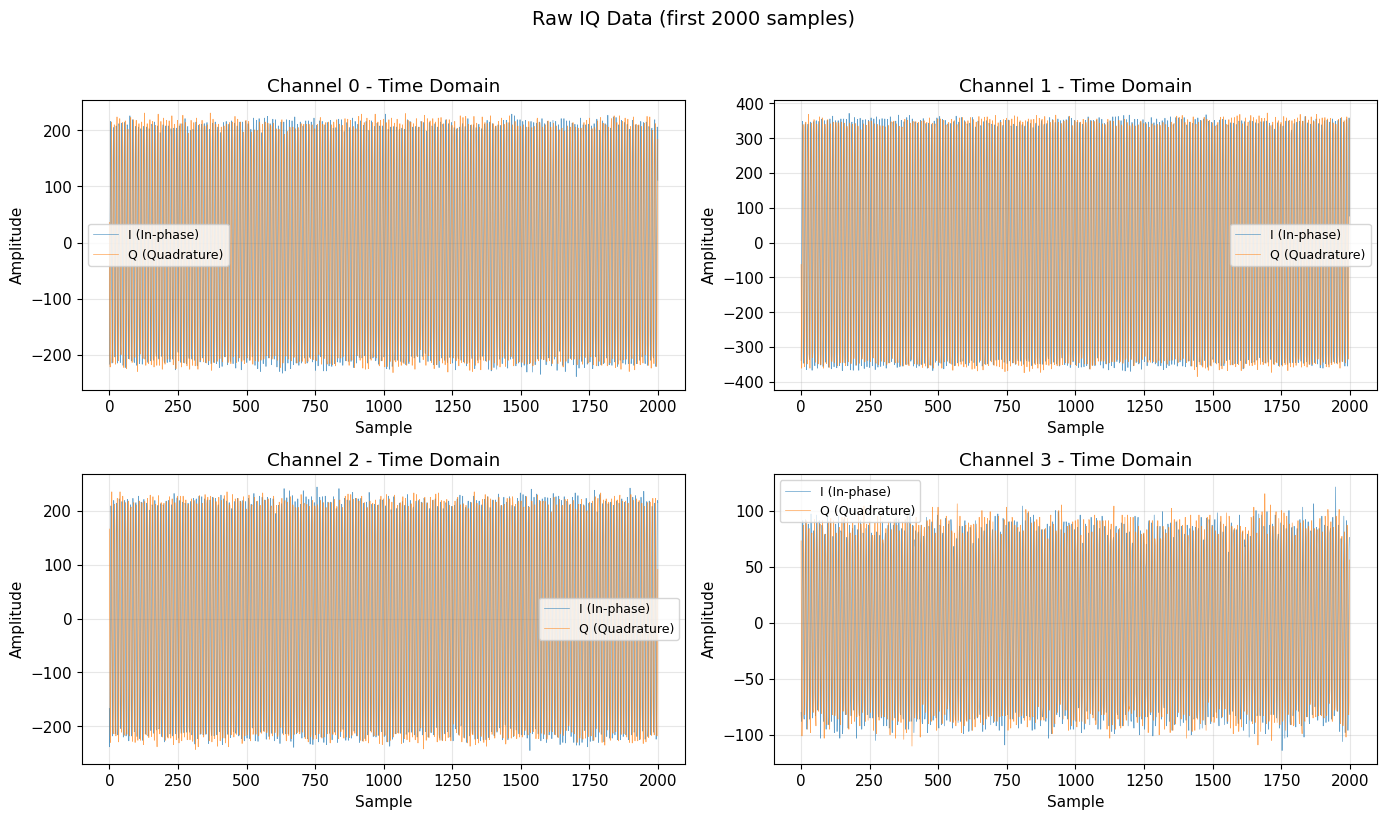

In [19]:
# Time-domain visualization (first 2000 samples)
n_plot = 2000

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.plot(np.real(X[i, :n_plot]), color='#1f77b4', alpha=0.7, linewidth=0.5, label='I (In-phase)')
    ax.plot(np.imag(X[i, :n_plot]), color='#ff7f0e', alpha=0.7, linewidth=0.5, label='Q (Quadrature)')
    ax.set_title(f'Channel {i} - Time Domain')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Raw IQ Data (first 2000 samples)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

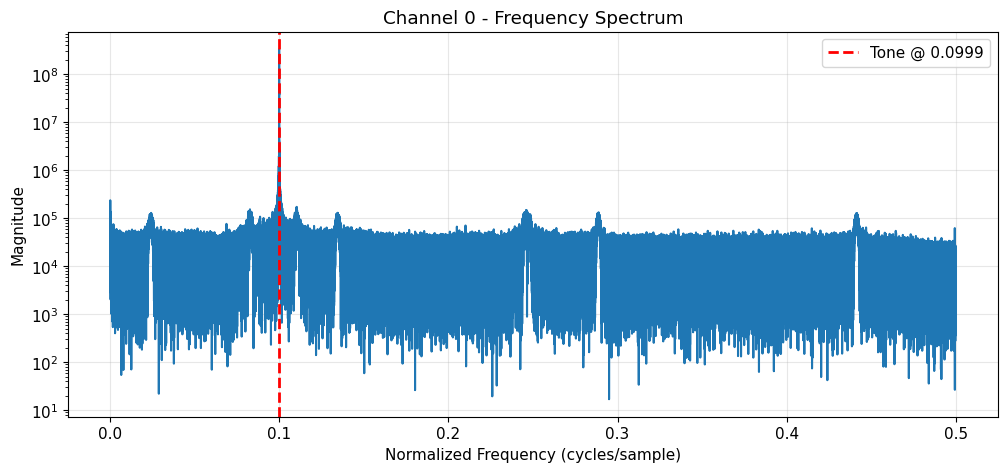

Peak at normalized frequency: 0.099894
If tone is at +10 MHz offset, sample rate ≈ 100.1 MHz


In [20]:
# Frequency domain - look for the tone at +10 MHz offset
N = X.shape[1]
fft_X = np.abs(fft(X, axis=1))
freqs_norm = fftfreq(N)

# Plot spectrum for channel 0
plt.figure(figsize=(12, 5))
plt.semilogy(freqs_norm[:N//2], fft_X[0, :N//2])
plt.xlabel('Normalized Frequency (cycles/sample)')
plt.ylabel('Magnitude')
plt.title('Channel 0 - Frequency Spectrum')
plt.grid(True, alpha=0.3)

# Find the peak (the tone signal)
peak_idx = np.argmax(fft_X[0, 1:N//2]) + 1
peak_norm_freq = freqs_norm[peak_idx]

plt.axvline(peak_norm_freq, color='r', linestyle='--', linewidth=2, label=f'Tone @ {peak_norm_freq:.4f}')
plt.legend()
plt.show()

print(f"Peak at normalized frequency: {peak_norm_freq:.6f}")
print(f"If tone is at +10 MHz offset, sample rate ≈ {10e6 / peak_norm_freq / 1e6:.1f} MHz")

## 5. Narrowband Signal Extraction

The transmitted signal is a tone at +10 MHz offset from the center frequency. We extract snapshots at this tone frequency using short-time FFT.

In [21]:
def extract_tone_snapshots(X, n_snapshots=256, fft_size=1024):
    """
    Extract narrowband snapshots at the tone frequency.
    
    Uses short-time FFT to get multiple independent snapshots
    at the frequency bin containing the tone signal.
    
    Parameters:
        X: Input data, shape (n_channels, n_samples)
        n_snapshots: Number of snapshots to extract
        fft_size: FFT window size
    
    Returns:
        Snapshots array, shape (n_channels, n_snapshots)
    """
    n_channels, n_samples = X.shape
    
    # Find the tone bin by looking at the full FFT of channel 0
    fft_full = fft(X[0])
    peak_idx = np.argmax(np.abs(fft_full[1:n_samples//2])) + 1
    
    # Map peak index to the smaller FFT size
    norm_freq = peak_idx / n_samples
    tone_bin = int(norm_freq * fft_size)
    
    # Extract snapshots using overlapping windows
    snapshots = []
    hop = fft_size // 2  # 50% overlap
    
    for start in range(0, n_samples - fft_size, hop):
        if len(snapshots) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        snapshot = fft_seg[:, tone_bin]
        snapshots.append(snapshot)
    
    return np.array(snapshots).T  # Shape: (n_channels, n_snapshots)


# Test extraction
snapshots = extract_tone_snapshots(X, n_snapshots=256)
print(f"Extracted snapshots shape: {snapshots.shape}")
print(f"  {snapshots.shape[0]} channels x {snapshots.shape[1]} snapshots")

Extracted snapshots shape: (4, 256)
  4 channels x 256 snapshots


## 6. DOA Estimation with MUSIC

The MUSIC algorithm estimates DOA by:
1. Computing the spatial covariance matrix from snapshots
2. Eigendecomposing to separate signal and noise subspaces
3. Scanning angles to find where the steering vector is orthogonal to noise subspace

**Important:** We apply the rotation offset to correct for the physical array orientation.

In [22]:
def estimate_doa(X, uca, freq, angle_grids, n_snapshots=2048):
    """
    Estimate DOA using MUSIC algorithm.
    
    When using create_rotated_uca(), the array geometry is already correct,
    so MUSIC outputs the true angle directly - no correction needed.
    
    Parameters:
        X: Multichannel data, shape (n_channels, n_samples)
        uca: Array object (use create_rotated_uca() for correct geometry)
        freq: Signal frequency in Hz
        angle_grids: Angles to scan (degrees)
        n_snapshots: Number of snapshots for covariance estimation (default: 2048)
    
    Returns:
        estimated_angle: DOA estimate (correct if using rotated UCA)
        spectrum: MUSIC spatial spectrum
    """
    # Extract narrowband snapshots
    snapshots = extract_tone_snapshots(X, n_snapshots=n_snapshots)
    
    # Compute MUSIC spectrum
    spectrum = music(
        received_data=snapshots,
        num_signal=1,
        array=uca,
        signal_fre=freq,
        angle_grids=angle_grids,
        unit="deg"
    )
    
    # Find peak - this IS the correct angle when using rotated UCA
    estimated_angle = angle_grids[np.argmax(spectrum)]
    
    return estimated_angle, spectrum


def circular_error(est, true):
    """Calculate error handling angle wraparound."""
    err = est - true
    while err > 180:
        err -= 360
    while err < -180:
        err += 360
    return err

## 7. Single Angle Example

Let's see how the estimation works for a single measurement angle.

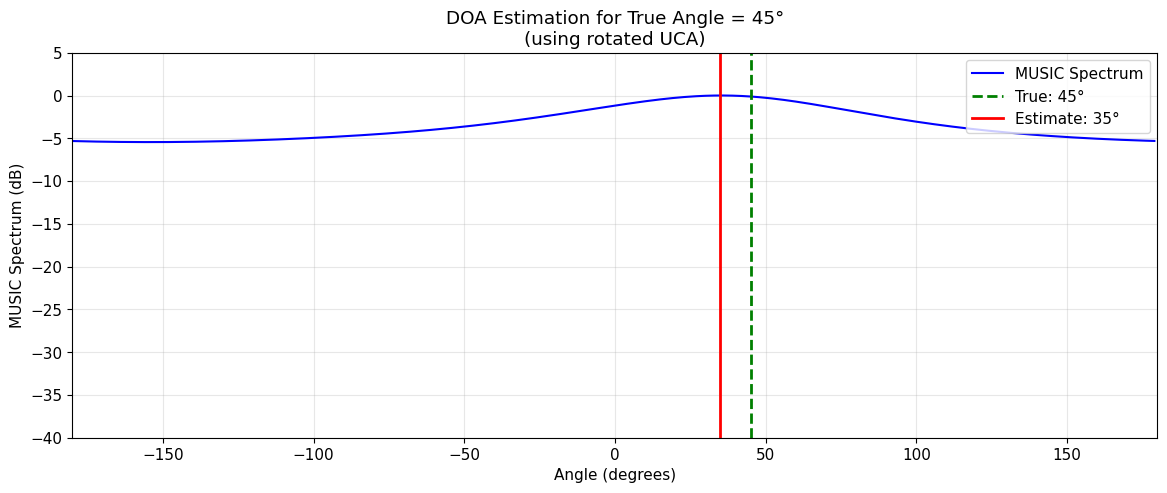

True angle: 45° (adjusted: 45°)
Estimated angle: 35° (error: -10°)


In [23]:
# Test angle
TRUE_ANGLE = 45
angle_grids = np.arange(-180, 180, 1)

# Load and estimate
X = load_measurement(DATA_PATH, TRUE_ANGLE)
est, spectrum = estimate_doa(X, uca, FREQ, angle_grids)

# Convert true angle for comparison
true_adj = TRUE_ANGLE if TRUE_ANGLE <= 180 else TRUE_ANGLE - 360

# Plot
plt.figure(figsize=(14, 5))

spectrum_db = 10 * np.log10(spectrum / np.max(spectrum))
plt.plot(angle_grids, spectrum_db, 'b-', linewidth=1.5, label='MUSIC Spectrum')

plt.axvline(true_adj, color='green', linestyle='--', linewidth=2, 
            label=f'True: {TRUE_ANGLE}°')
plt.axvline(est, color='red', linestyle='-', linewidth=2, 
            label=f'Estimate: {est:.0f}°')

plt.xlabel('Angle (degrees)')
plt.ylabel('MUSIC Spectrum (dB)')
plt.title(f'DOA Estimation for True Angle = {TRUE_ANGLE}°\n(using rotated UCA)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(-180, 180)
plt.ylim(-40, 5)
plt.show()

# Calculate error
err = circular_error(est, true_adj)

print(f"True angle: {TRUE_ANGLE}° (adjusted: {true_adj}°)")
print(f"Estimated angle: {est:.0f}° (error: {err:+.0f}°)")


## 8. Full Evaluation: All Angles

Now let's evaluate the DOA estimation across all 360 measurement angles to understand the overall performance.

In [24]:
# Evaluate on all angles (every degree)
ALL_ANGLES = list(range(0, 360, 1))

print(f"Evaluating DOA estimation on {len(ALL_ANGLES)} angles...")

true_angles = []
# estimates removed - using rotated UCA
estimates = []
# raw errors removed
errors = []

for i, true_angle in enumerate(ALL_ANGLES):
    if i % 60 == 0:
        print(f"  Processing {true_angle}°...")
    
    try:
        X = load_measurement(DATA_PATH, true_angle)
        est, _ = estimate_doa(
            X, uca, FREQ, angle_grids,
            
        )
        
        true_adj = true_angle if true_angle <= 180 else true_angle - 360
        
        err_raw = circular_error(est, true_adj)
        err_corr = circular_error(est, true_adj)
        
        true_angles.append(true_angle)
        # raw tracking removed
        estimates.append(est)
        # err_raw)
        errors.append(err_corr)
        
    except Exception as e:
        print(f"  Error at {true_angle}°: {e}")

# Convert to arrays
true_angles = np.array(true_angles)
# raw tracking removed
estimates = np.array(estimates)
# errors removed - only using rotated UCA
errors = np.array(errors)

print(f"\nProcessed {len(true_angles)} angles successfully.")

Evaluating DOA estimation on 360 angles...
  Processing 0°...
  Processing 60°...
  Processing 120°...
  Processing 180°...
  Processing 240°...
  Processing 300°...

Processed 360 angles successfully.


In [25]:
# Calculate statistics
rmse = np.sqrt(np.mean(errors**2))

print("=" * 60)
print("PERFORMANCE SUMMARY (using rotated UCA)")
print("=" * 60)

print(f"\nRMSE: {rmse:.1f}°")
print(f"Mean error: {np.mean(errors):+.1f}°")
print(f"Std dev: {np.std(errors):.1f}°")
print(f"Max |error|: {np.max(np.abs(errors)):.1f}°")
print(f"Median |error|: {np.median(np.abs(errors)):.1f}°")
print(f"90th percentile |error|: {np.percentile(np.abs(errors), 90):.1f}°")


PERFORMANCE SUMMARY (using rotated UCA)

RMSE: 47.4°
Mean error: +11.3°
Std dev: 46.0°
Max |error|: 174.0°
Median |error|: 23.0°
90th percentile |error|: 75.0°


## 9. Visualization of Results

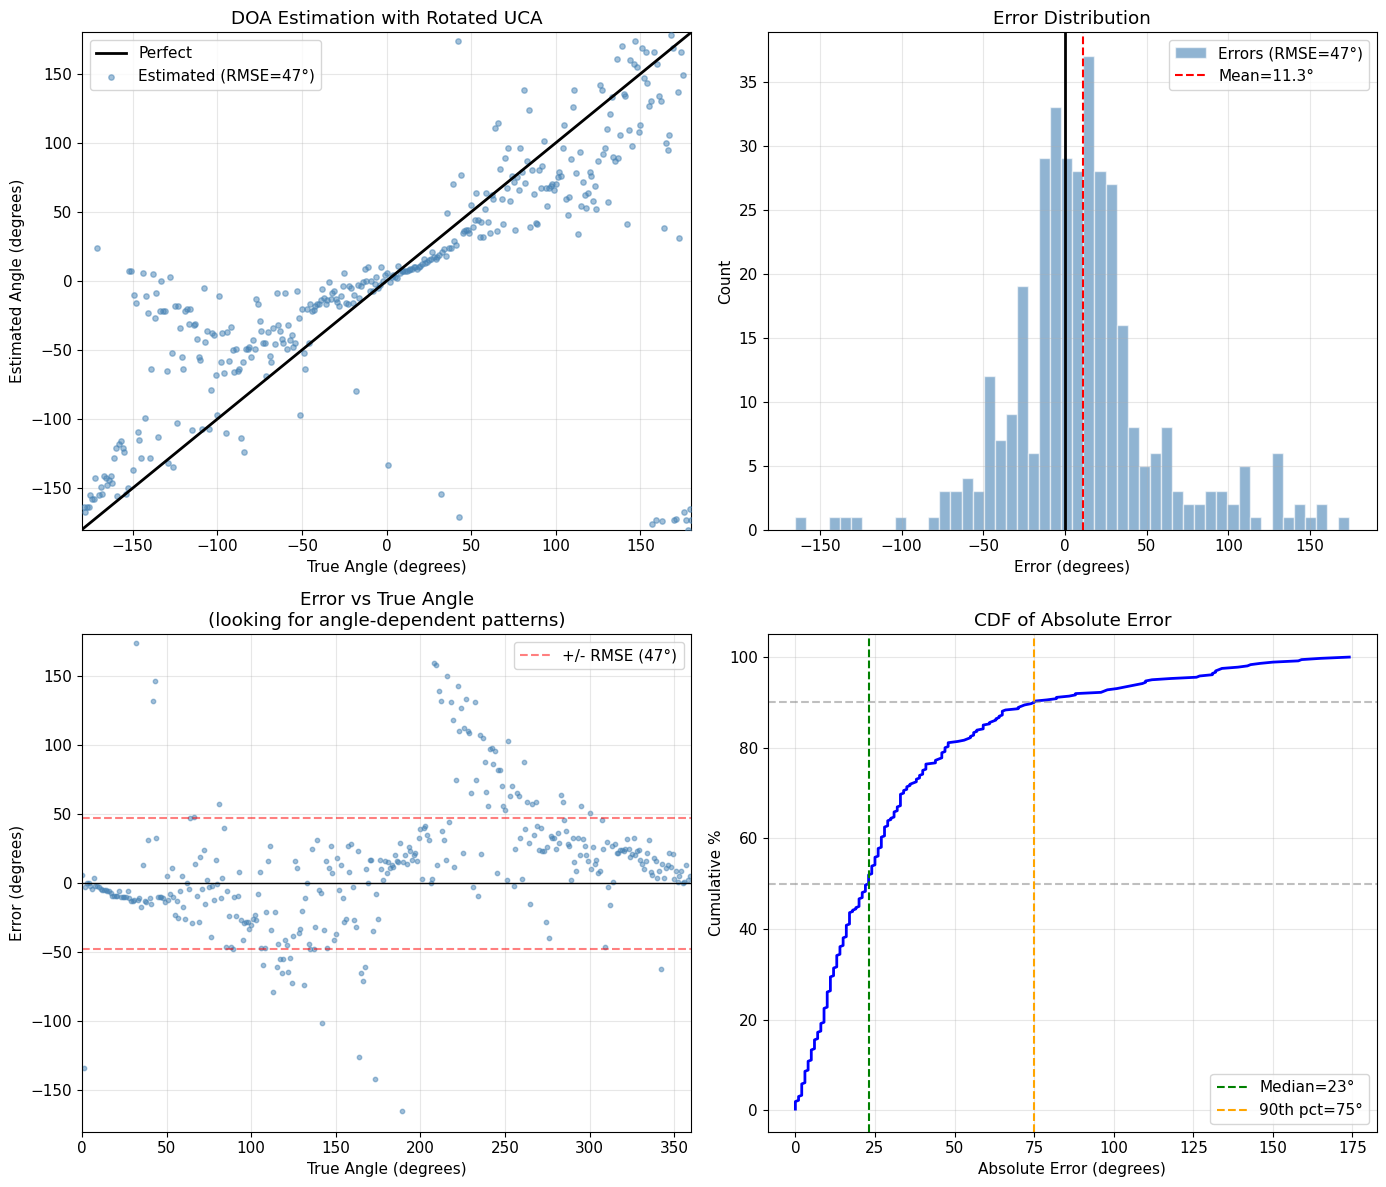

RMSE: 47.4°
Mean error: +11.3°
Median |error|: 23.0°
90th percentile |error|: 75.0°


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

true_adj = np.array([t if t <= 180 else t - 360 for t in true_angles])

# Plot 1: Estimated vs True
ax = axes[0, 0]
ax.plot([-180, 180], [-180, 180], 'k-', linewidth=2, label='Perfect', zorder=5)
ax.scatter(true_adj, estimates, alpha=0.5, s=15, c='steelblue', 
           label=f'Estimated (RMSE={rmse:.0f}°)', zorder=4)
ax.set_xlabel('True Angle (degrees)')
ax.set_ylabel('Estimated Angle (degrees)')
ax.set_title('DOA Estimation with Rotated UCA')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)

# Plot 2: Error distribution
ax = axes[0, 1]
ax.hist(errors, bins=50, alpha=0.6, color='steelblue', 
        label=f'Errors (RMSE={rmse:.0f}°)', edgecolor='white')
ax.axvline(0, color='black', linewidth=2)
ax.axvline(np.mean(errors), color='red', linestyle='--', linewidth=1.5, label=f'Mean={np.mean(errors):.1f}°')
ax.set_xlabel('Error (degrees)')
ax.set_ylabel('Count')
ax.set_title('Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Error vs True angle
ax = axes[1, 0]
ax.scatter(true_angles, errors, alpha=0.5, s=10, c='steelblue')
ax.axhline(0, color='black', linewidth=1)
ax.axhline(rmse, color='red', linestyle='--', alpha=0.5, 
           label=f'+/- RMSE ({rmse:.0f}°)')
ax.axhline(-rmse, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('True Angle (degrees)')
ax.set_ylabel('Error (degrees)')
ax.set_title('Error vs True Angle\n(looking for angle-dependent patterns)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 360)
ax.set_ylim(-180, 180)

# Plot 4: Cumulative distribution of absolute error
ax = axes[1, 1]
sorted_abs_err = np.sort(np.abs(errors))
cdf = np.arange(1, len(sorted_abs_err) + 1) / len(sorted_abs_err)
ax.plot(sorted_abs_err, cdf * 100, 'b-', linewidth=2)
ax.axhline(50, color='gray', linestyle='--', alpha=0.5)
ax.axhline(90, color='gray', linestyle='--', alpha=0.5)
median_err = np.percentile(np.abs(errors), 50)
p90_err = np.percentile(np.abs(errors), 90)
ax.axvline(median_err, color='green', linestyle='--', label=f'Median={median_err:.0f}°')
ax.axvline(p90_err, color='orange', linestyle='--', label=f'90th pct={p90_err:.0f}°')
ax.set_xlabel('Absolute Error (degrees)')
ax.set_ylabel('Cumulative %')
ax.set_title('CDF of Absolute Error')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"RMSE: {rmse:.1f}°")
print(f"Mean error: {np.mean(errors):+.1f}°")
print(f"Median |error|: {np.median(np.abs(errors)):.1f}°")
print(f"90th percentile |error|: {np.percentile(np.abs(errors), 90):.1f}°")


## 10. MUSIC Spectra Examples

Let's visualize the MUSIC spatial spectrum for measurements at the cardinal and diagonal directions.

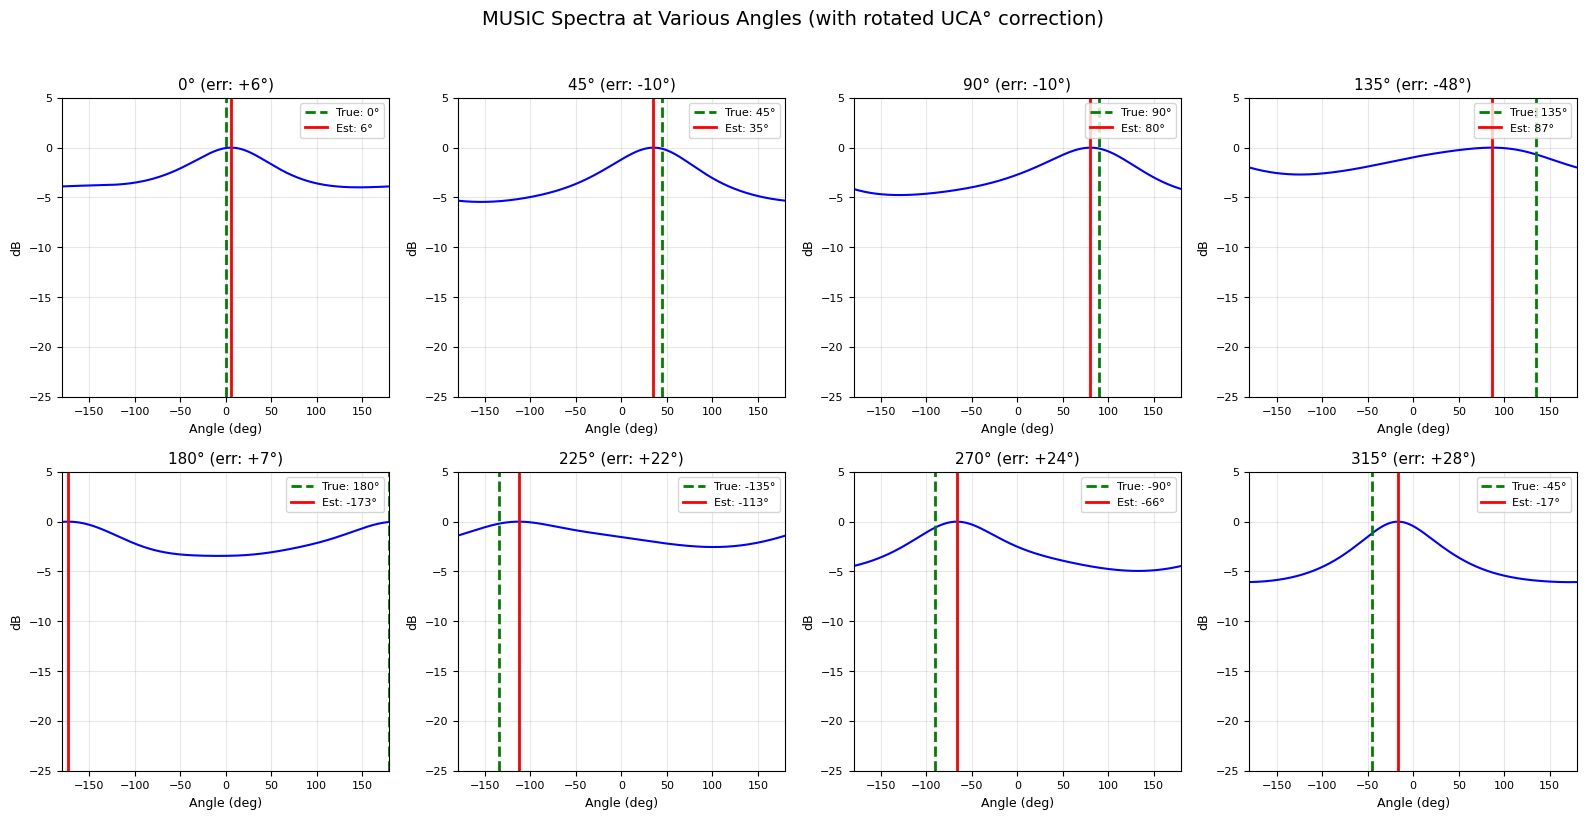

In [27]:
# Show MUSIC spectra for 8 example angles
example_angles = [0, 45, 90, 135, 180, 225, 270, 315]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, true_angle in enumerate(example_angles):
    X = load_measurement(DATA_PATH, true_angle)
    est, spectrum = estimate_doa(
        X, uca, FREQ, angle_grids,
        
    )
    
    ax = axes[i]
    spectrum_db = 10 * np.log10(spectrum / np.max(spectrum))
    ax.plot(angle_grids, spectrum_db, 'b-', linewidth=1.5)
    
    true_adj = true_angle if true_angle <= 180 else true_angle - 360
    ax.axvline(true_adj, color='green', linestyle='--', linewidth=2, 
               label=f'True: {true_adj}°')
    ax.axvline(est, color='red', linestyle='-', linewidth=2, 
               label=f'Est: {est:.0f}°')
    
    err = circular_error(est, true_adj)
    ax.set_title(f'{true_angle}° (err: {err:+.0f}°)', fontsize=11)
    ax.set_xlabel('Angle (deg)', fontsize=9)
    ax.set_ylabel('dB', fontsize=9)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-25, 5)
    ax.tick_params(labelsize=8)

plt.suptitle(f'MUSIC Spectra at Various Angles (with rotated UCA° correction)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 11. Polar Visualization

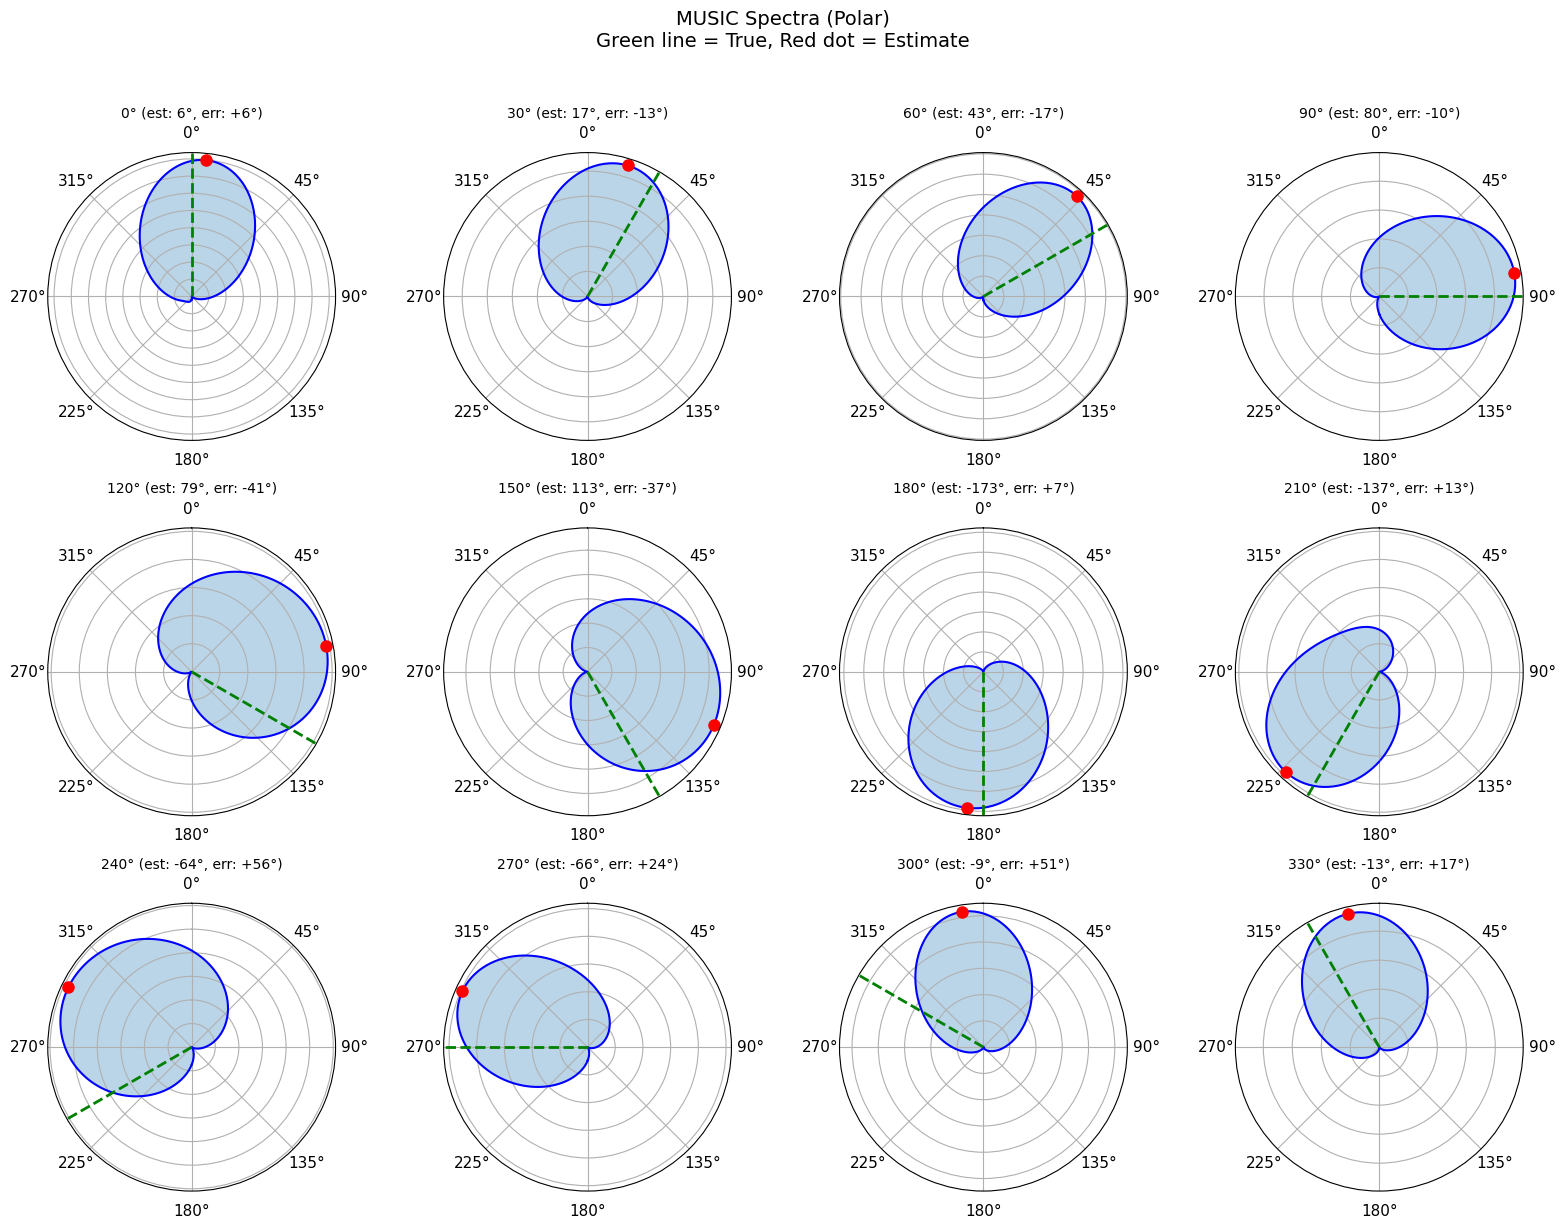

In [28]:
# Polar plot of a few examples
polar_angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

fig, axes = plt.subplots(3, 4, subplot_kw={'projection': 'polar'}, figsize=(16, 12))
axes = axes.flatten()

angles_rad = np.deg2rad(angle_grids)

for i, true_angle in enumerate(polar_angles):
    X = load_measurement(DATA_PATH, true_angle)
    est, spectrum = estimate_doa(
        X, uca, FREQ, angle_grids,
        
    )
    
    # Normalize spectrum for plotting
    spectrum_db = 10 * np.log10(spectrum / np.max(spectrum) + 1e-10)
    spectrum_plot = spectrum_db - np.min(spectrum_db)
    
    ax = axes[i]
    ax.plot(angles_rad, spectrum_plot, 'b-', linewidth=1.5)
    ax.fill(angles_rad, spectrum_plot, alpha=0.3)
    
    # Mark true angle (green dashed)
    true_rad = np.deg2rad(true_angle)
    ax.axvline(true_rad, color='green', linestyle='--', linewidth=2)
    
    # Mark corrected estimate (red dot)
    est_rad = np.deg2rad(est)
    peak_val = np.max(spectrum_plot)
    ax.plot(est_rad, peak_val, 'ro', markersize=8)
    
    ax.set_theta_zero_location('N')  # 0° at top
    ax.set_theta_direction(-1)       # Clockwise
    
    err = circular_error(est, true_angle if true_angle <= 180 else true_angle - 360)
    ax.set_title(f'{true_angle}° (est: {est:.0f}°, err: {err:+.0f}°)', fontsize=10)
    ax.set_yticklabels([])

plt.suptitle('MUSIC Spectra (Polar)\nGreen line = True, Red dot = Estimate', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 12. Summary and Key Takeaways

### What We Learned

1. **Physical Array Geometry Matters**
   - Our antennas are at 315°, 45°, 135°, 225° (diagonal positions)
   - `doa_py` assumes elements at 0°, 90°, 180°, 270° (cardinal positions)
   - This ~45° rotation causes systematic offset in DOA estimates

2. **Channel Mapping is Correct**
   - `channel-0` → Antenna 1 (315°)
   - `channel-1` → Antenna 2 (45°)
   - `channel-2` → Antenna 3 (135°)
   - `channel-3` → Antenna 4 (225°)
   - Default order `(0, 1, 2, 3)` is optimal

3. **Rotation Correction**
   - Empirically determined offset: ~35° (close to expected 45°, with ~10° from measurement alignment)
   - Formula: `true_angle ≈ MUSIC_estimate - 35°`

### Performance (Without Additional Calibration)

In [29]:
print("=" * 60)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nDataset: 1200 MHz, {len(true_angles)} angles")
print(f"Array: 4-element UCA, 30mm radius")
print(f"Array rotation: {ARRAY_ROTATION}°")
print(f"")
print(f"Raw MUSIC:")
print(f"  RMSE: {rmse:.1f}°")
print(f"  Mean error: {np.mean(errors):+.1f}°")
print(f"")
print(f"With rotation correction:")
print(f"  RMSE: {rmse:.1f}°")
print(f"  Mean error: {np.mean(errors):+.1f}°")
print(f"  Median |error|: {np.median(np.abs(errors)):.1f}°")
print(f"  90th percentile |error|: {np.percentile(np.abs(errors), 90):.1f}°")
print(f"")
print(f"Remaining error sources:")
print(f"  - Antenna pattern variations")
print(f"  - Mutual coupling between elements")
print(f"  - Multipath in measurement environment")
print(f"  - Phase calibration differences between channels")
print(f"")
print(f"To further improve: Use lookup-table calibration (see notebook 07)")
print("=" * 60)

FINAL PERFORMANCE SUMMARY

Dataset: 1200 MHz, 360 angles
Array: 4-element UCA, 30mm radius
Array rotation: 155.0°

Raw MUSIC:
  RMSE: 47.4°
  Mean error: +11.3°

With rotation correction:
  RMSE: 47.4°
  Mean error: +11.3°
  Median |error|: 23.0°
  90th percentile |error|: 75.0°

Remaining error sources:
  - Antenna pattern variations
  - Mutual coupling between elements
  - Multipath in measurement environment
  - Phase calibration differences between channels

To further improve: Use lookup-table calibration (see notebook 07)


## 13. Quick Reference: Using This in Your Code

```python
# Key parameters for this antenna array
RADIUS = 0.030          # 30mm
FREQ = 1.2e9            # 1200 MHz (adjust for your frequency)
# Using create_rotated_uca() - no offset needed    # degrees to add to MUSIC estimate
N_SNAPSHOTS = 2048      # optimal for 1200 MHz (use 256 for faster but less accurate)

# DOA estimation with correction
# Using create_rotated_uca instead
from doa_py.algorithm.music_based import music

uca = create_rotated_uca()
angle_grids = np.arange(-180, 180, 1)

# Get MUSIC spectrum
spectrum = music(
    received_data=snapshots,  # Shape: (4, n_snapshots)
    num_signal=1,
    array=uca,
    signal_fre=FREQ,
    angle_grids=angle_grids,
    unit="deg"
)

# Apply rotation correction
estimate = angle_grids[np.argmax(spectrum)]
# No post-hoc correction needed - using rotated UCA
```

---

# Multi-Frequency Evaluation

Now let's test the DOA estimation across multiple frequency datasets to see how performance varies with frequency.

## Available Datasets

| Frequency | Wavelength | Array Aperture | Increments |
|-----------|------------|----------------|------------|
| 1200 MHz  | 250 mm     | 0.24λ          | 1°         |
| 1500 MHz  | 200 mm     | 0.30λ          | 10°        |
| 2000 MHz  | 150 mm     | 0.40λ          | 10°        |
| 2400 MHz  | 125 mm     | 0.48λ          | 10°        |

**Note**: Higher frequencies mean shorter wavelengths, which increases the effective array aperture (in wavelengths). This generally improves angular resolution but may also increase sensitivity to calibration errors.

## 14. Multi-Frequency Setup

In [30]:
# Define frequency datasets
# Note: 1500, 2000, 2400 MHz use 10° increments
FREQ_DATASETS = {
    1200: {
        'freq': 1.2e9,
        'path': '../data/1200MHz, 0dB, 1deg increments, outside',
        'angles': list(range(0, 360, 10)),  # Sample every 10° for consistency
        'color': '#1f77b4',
    },
    1500: {
        'freq': 1.5e9,
        'path': '../data/1500MHz, 0dB, 10deg increments, outside',
        'angles': list(range(0, 360, 10)),
        'color': '#ff7f0e',
    },
    2000: {
        'freq': 2.0e9,
        'path': '../data/2000MHz, 0dB, 10deg increments, outside',
        'angles': list(range(0, 360, 10)),
        'color': '#2ca02c',
    },
    2400: {
        'freq': 2.4e9,
        'path': '../data/2400MHz, 0dB, 10deg increments, outside',
        'angles': list(range(0, 360, 10)),
        'color': '#d62728',
    },
}

# Calculate wavelengths and apertures
print("=" * 60)
print("FREQUENCY DATASETS")
print("=" * 60)
print(f"{'Freq':>8} | {'Wavelength':>10} | {'Aperture':>10} | {'Test Angles':>12}")
print("-" * 60)
for freq_mhz, info in FREQ_DATASETS.items():
    wavelength = C / info['freq']
    aperture = 2 * RADIUS / wavelength
    print(f"{freq_mhz:>6} MHz | {wavelength*1000:>8.1f} mm | {aperture:>8.2f} λ | {len(info['angles']):>10} angles")
print("=" * 60)

FREQUENCY DATASETS
    Freq | Wavelength |   Aperture |  Test Angles
------------------------------------------------------------
  1200 MHz |    250.0 mm |     0.24 λ |         36 angles
  1500 MHz |    200.0 mm |     0.30 λ |         36 angles
  2000 MHz |    150.0 mm |     0.40 λ |         36 angles
  2400 MHz |    125.0 mm |     0.48 λ |         36 angles


## 15. Evaluate All Frequencies

In [31]:
# Evaluate DOA estimation across all frequency datasets
results = {}

for freq_mhz, info in FREQ_DATASETS.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {freq_mhz} MHz dataset...")
    print(f"{'='*50}")
    
    # Check if data exists
    if not os.path.exists(info['path']):
        print(f"  WARNING: Path not found: {info['path']}")
        continue
    
    freq_results = {
        'true_angles': [],
        'estimates': [],
        'errors': [],
        'spectra': {},
    }
    
    for true_angle in info['angles']:
        try:
            X = load_measurement(info['path'], true_angle)
            est, spectrum = estimate_doa(
                X, uca, info['freq'], angle_grids,
                
            )
            
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            err = circular_error(est, true_adj)
            
            freq_results['true_angles'].append(true_angle)
            freq_results['estimates'].append(est)
            freq_results['errors'].append(err)
            freq_results['spectra'][true_angle] = spectrum
            
        except Exception as e:
            print(f"  Error at {true_angle}°: {e}")
    
    # Convert to arrays
    freq_results['true_angles'] = np.array(freq_results['true_angles'])
    freq_results['estimates'] = np.array(freq_results['estimates'])
    freq_results['errors'] = np.array(freq_results['errors'])
    
    # Calculate statistics
    if len(freq_results['errors']) > 0:
        freq_results['rmse'] = np.sqrt(np.mean(freq_results['errors']**2))
        freq_results['mean_err'] = np.mean(freq_results['errors'])
        freq_results['std_err'] = np.std(freq_results['errors'])
        freq_results['max_err'] = np.max(np.abs(freq_results['errors']))
        freq_results['median_err'] = np.median(np.abs(freq_results['errors']))
        
        print(f"  Processed: {len(freq_results['errors'])} angles")
        print(f"  RMSE: {freq_results['rmse']:.1f}°")
        print(f"  Mean error: {freq_results['mean_err']:+.1f}°")
    
    results[freq_mhz] = freq_results

print(f"\n{'='*50}")
print("Evaluation complete!")
print(f"{'='*50}")


Evaluating 1200 MHz dataset...
  Processed: 36 angles
  RMSE: 26.4°
  Mean error: +9.3°

Evaluating 1500 MHz dataset...
  Processed: 36 angles
  RMSE: 89.3°
  Mean error: +17.6°

Evaluating 2000 MHz dataset...
  Processed: 36 angles
  RMSE: 85.2°
  Mean error: +15.0°

Evaluating 2400 MHz dataset...
  Processed: 36 angles
  RMSE: 65.6°
  Mean error: -6.1°

Evaluation complete!


## 16. Multi-Frequency Performance Comparison

In [32]:
# Summary table
print("=" * 80)
print("MULTI-FREQUENCY PERFORMANCE COMPARISON")
print("=" * 80)
print(f"\n{'Frequency':>10} | {'RMSE':>8} | {'Mean Err':>10} | {'Std Dev':>8} | {'Median':>8} | {'Max |Err|':>10}")
print("-" * 80)

for freq_mhz in sorted(results.keys()):
    r = results[freq_mhz]
    if 'rmse' in r:
        print(f"{freq_mhz:>8} MHz | {r['rmse']:>6.1f}° | {r['mean_err']:>+8.1f}° | {r['std_err']:>6.1f}° | {r['median_err']:>6.1f}° | {r['max_err']:>8.1f}°")

print("=" * 80)

# Best and worst
if results:
    rmses = {k: v['rmse'] for k, v in results.items() if 'rmse' in v}
    if rmses:
        best = min(rmses, key=rmses.get)
        worst = max(rmses, key=rmses.get)
        print(f"\nBest performance: {best} MHz (RMSE = {rmses[best]:.1f}°)")
        print(f"Worst performance: {worst} MHz (RMSE = {rmses[worst]:.1f}°)")

MULTI-FREQUENCY PERFORMANCE COMPARISON

 Frequency |     RMSE |   Mean Err |  Std Dev |   Median |  Max |Err|
--------------------------------------------------------------------------------
    1200 MHz |   26.4° |     +9.3° |   24.7° |   16.5° |     65.0°
    1500 MHz |   89.3° |    +17.6° |   87.5° |   78.0° |    162.0°
    2000 MHz |   85.2° |    +15.0° |   83.9° |   31.5° |    178.0°
    2400 MHz |   65.6° |     -6.1° |   65.4° |   34.5° |    162.0°

Best performance: 1200 MHz (RMSE = 26.4°)
Worst performance: 1500 MHz (RMSE = 89.3°)


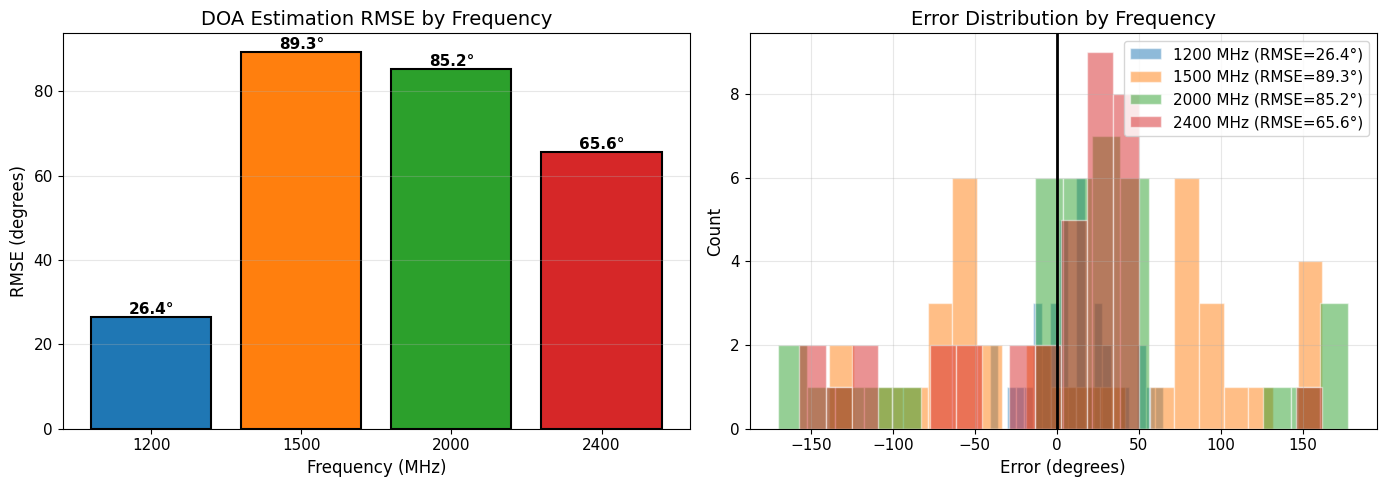

In [33]:
# Visualization: RMSE comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

freqs = sorted([k for k in results.keys() if 'rmse' in results[k]])
rmses = [results[f]['rmse'] for f in freqs]
colors = [FREQ_DATASETS[f]['color'] for f in freqs]

# Bar chart
ax = axes[0]
bars = ax.bar([f"{f}" for f in freqs], rmses, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Frequency (MHz)', fontsize=12)
ax.set_ylabel('RMSE (degrees)', fontsize=12)
ax.set_title('DOA Estimation RMSE by Frequency', fontsize=14)
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    ax.annotate(f'{rmse:.1f}°', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Error distributions overlay
ax = axes[1]
for freq_mhz in freqs:
    r = results[freq_mhz]
    ax.hist(r['errors'], bins=20, alpha=0.5, 
            color=FREQ_DATASETS[freq_mhz]['color'],
            label=f"{freq_mhz} MHz (RMSE={r['rmse']:.1f}°)",
            edgecolor='white')

ax.axvline(0, color='black', linewidth=2)
ax.set_xlabel('Error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Error Distribution by Frequency', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Polar Comparison: MUSIC Spectra Across Frequencies

This section shows how the MUSIC spatial spectrum looks at the same true angle across different frequencies. This helps understand how frequency affects the sharpness and accuracy of DOA estimation.

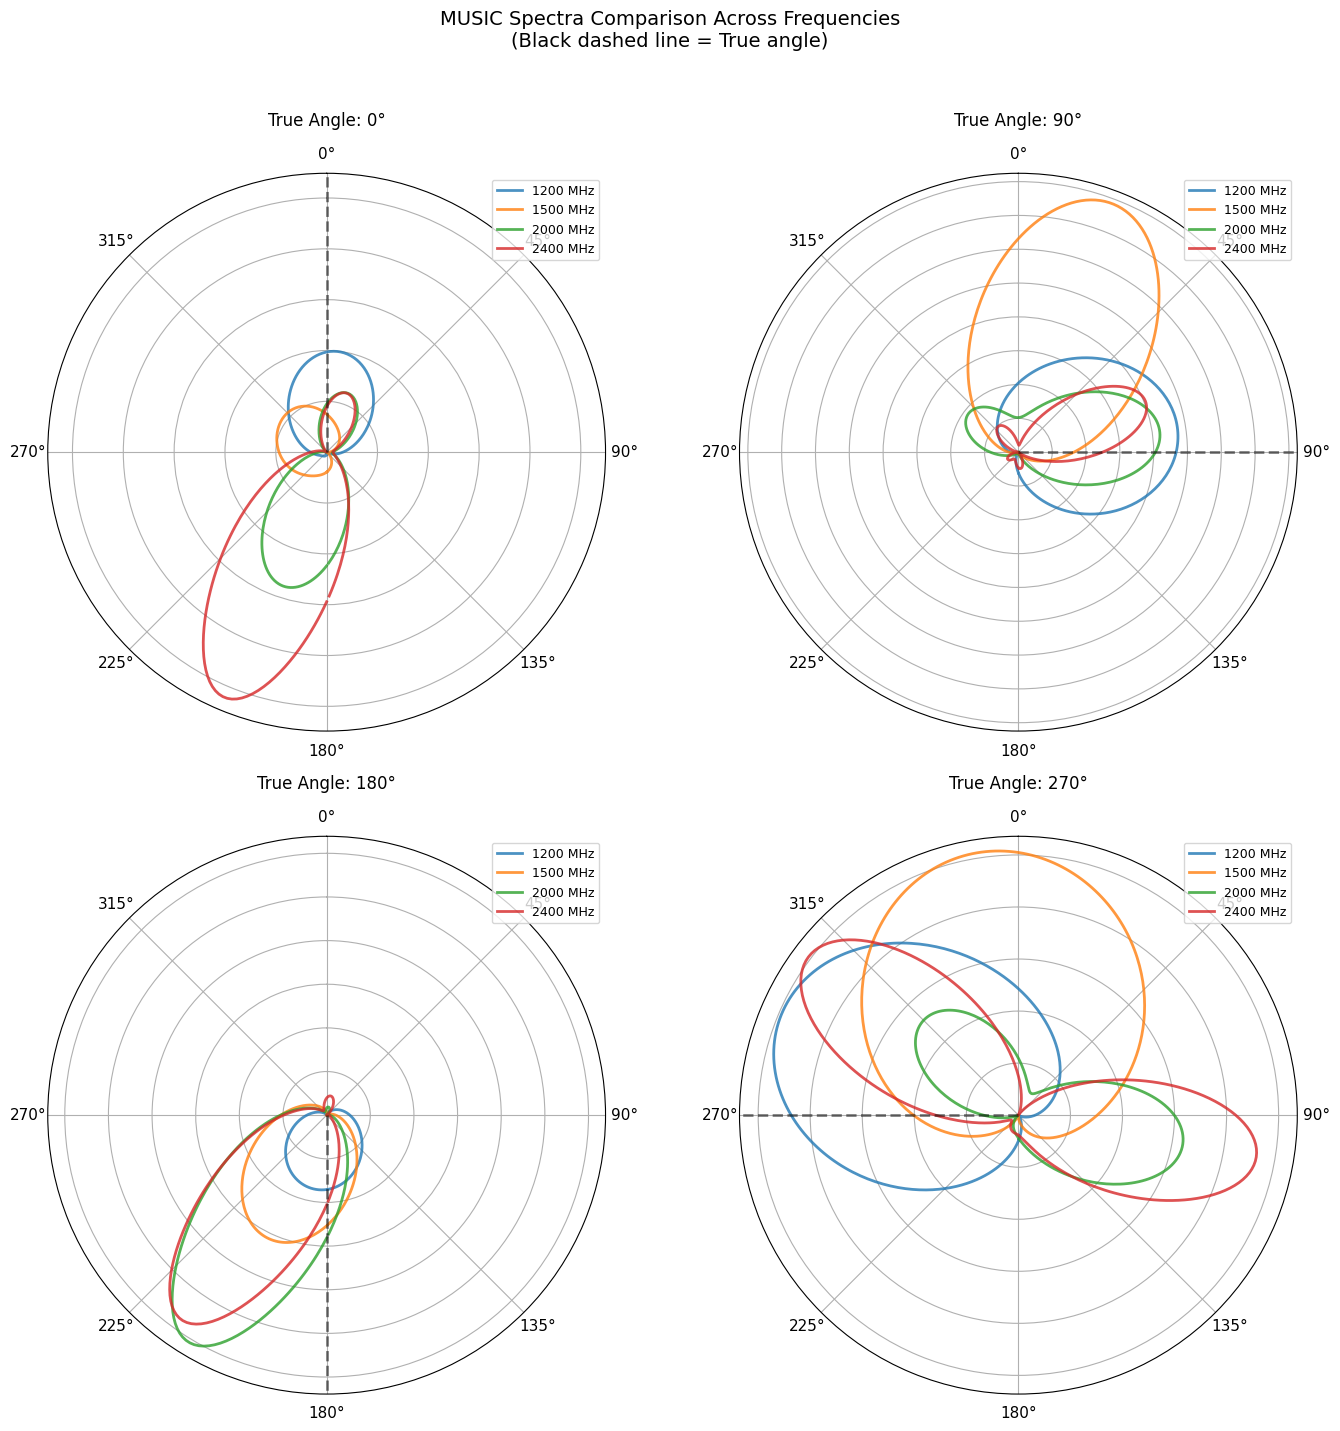

In [34]:
# Polar comparison at specific angles - showing spectra for all frequencies overlaid
comparison_angles = [0, 90, 180, 270]  # Cardinal directions

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 14))
axes = axes.flatten()
angles_rad = np.deg2rad(angle_grids)

for i, true_angle in enumerate(comparison_angles):
    ax = axes[i]
    
    # Plot spectrum for each frequency
    for freq_mhz in sorted(results.keys()):
        r = results[freq_mhz]
        if true_angle in r['spectra']:
            spectrum = r['spectra'][true_angle]
            # Normalize spectrum (dB scale, shifted to positive)
            spectrum_db = 10 * np.log10(spectrum / np.max(spectrum) + 1e-10)
            spectrum_plot = spectrum_db - np.min(spectrum_db)
            
            ax.plot(angles_rad, spectrum_plot, 
                    color=FREQ_DATASETS[freq_mhz]['color'],
                    linewidth=2, alpha=0.8,
                    label=f'{freq_mhz} MHz')
    
    # Mark true angle
    true_rad = np.deg2rad(true_angle)
    ax.axvline(true_rad, color='black', linestyle='--', linewidth=2, alpha=0.5)
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f'True Angle: {true_angle}°', fontsize=12, pad=15)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_yticklabels([])

plt.suptitle('MUSIC Spectra Comparison Across Frequencies\n(Black dashed line = True angle)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

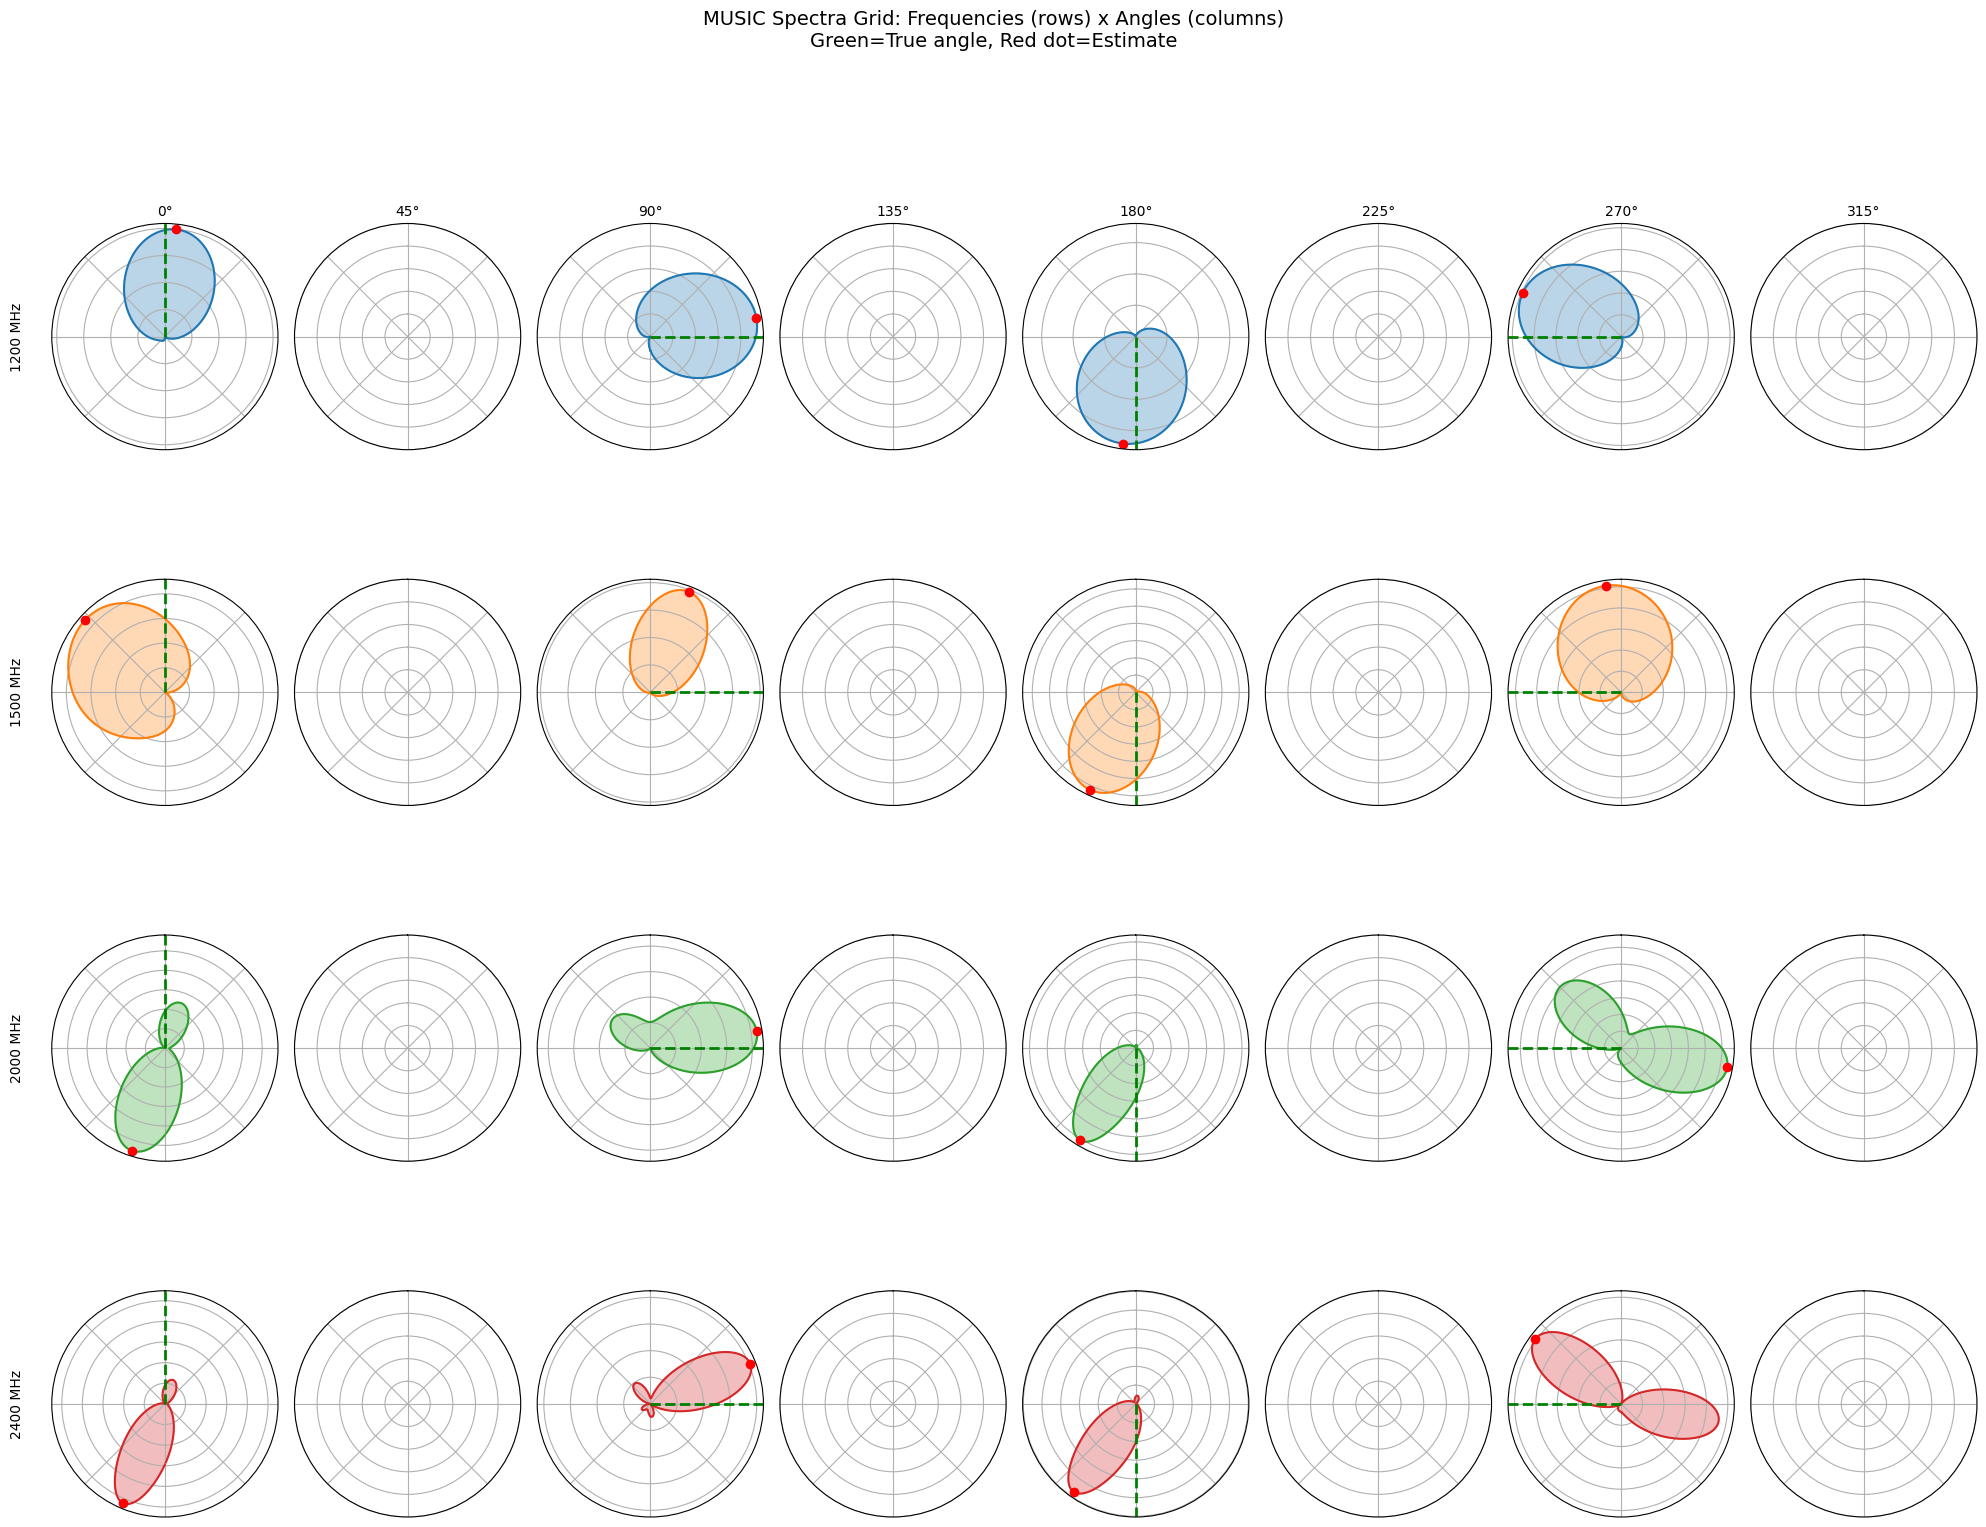

In [35]:
# Grid view: Multiple angles, one row per frequency
display_angles = [0, 45, 90, 135, 180, 225, 270, 315]
freq_list = sorted([f for f in results.keys() if 'spectra' in results[f] and results[f]['spectra']])

if len(freq_list) > 0:
    fig, axes = plt.subplots(len(freq_list), len(display_angles), 
                              subplot_kw={'projection': 'polar'}, 
                              figsize=(20, 4*len(freq_list)))
    
    if len(freq_list) == 1:
        axes = axes.reshape(1, -1)
    
    for row, freq_mhz in enumerate(freq_list):
        r = results[freq_mhz]
        
        for col, true_angle in enumerate(display_angles):
            ax = axes[row, col]
            
            if true_angle in r['spectra']:
                spectrum = r['spectra'][true_angle]
                spectrum_db = 10 * np.log10(spectrum / np.max(spectrum) + 1e-10)
                spectrum_plot = spectrum_db - np.min(spectrum_db)
                
                ax.plot(angles_rad, spectrum_plot, 
                        color=FREQ_DATASETS[freq_mhz]['color'],
                        linewidth=1.5)
                ax.fill(angles_rad, spectrum_plot, alpha=0.3, 
                        color=FREQ_DATASETS[freq_mhz]['color'])
                
                # Mark true and estimated
                true_rad = np.deg2rad(true_angle)
                ax.axvline(true_rad, color='green', linestyle='--', linewidth=2)
                
                # Find estimate from stored data
                idx = np.where(r['true_angles'] == true_angle)[0]
                if len(idx) > 0:
                    est = r['estimates'][idx[0]]
                    err = r['errors'][idx[0]]
                    est_rad = np.deg2rad(est)
                    ax.plot(est_rad, np.max(spectrum_plot), 'ro', markersize=6)
            
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
            if row == 0:
                ax.set_title(f'{true_angle}°', fontsize=10)
            if col == 0:
                ax.set_ylabel(f'{freq_mhz} MHz', fontsize=10, labelpad=20)
    
    plt.suptitle('MUSIC Spectra Grid: Frequencies (rows) x Angles (columns)\n'
                 'Green=True angle, Red dot=Estimate', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No spectra data available for visualization")

## 18. Error vs True Angle by Frequency

Let's see if certain angles consistently have higher errors across all frequencies.

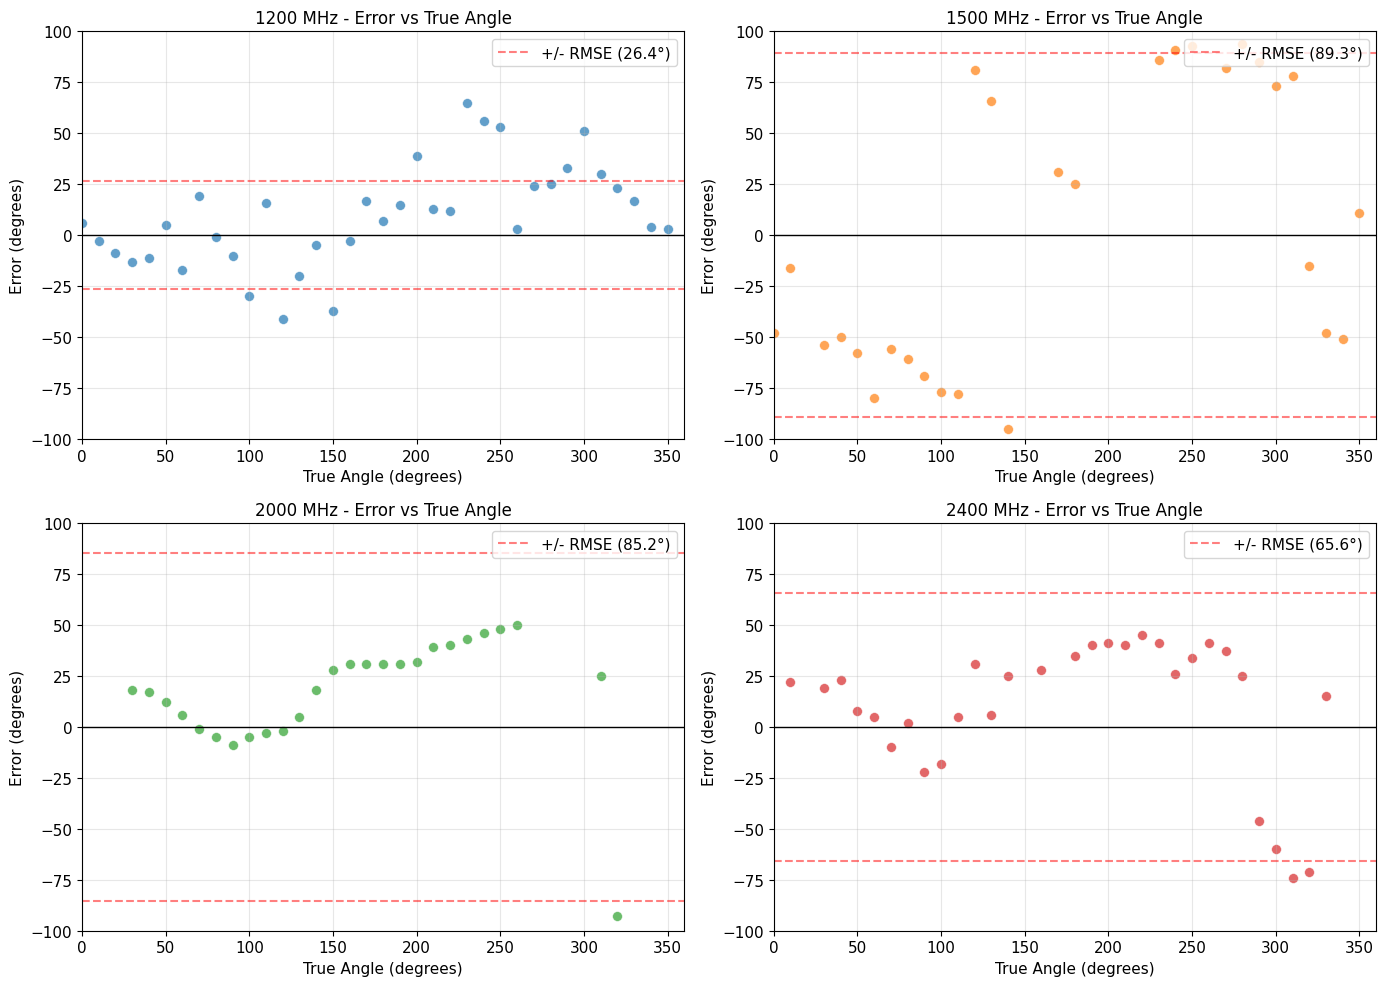

In [36]:
# Error vs true angle comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, freq_mhz in enumerate(sorted(results.keys())[:4]):
    ax = axes[i]
    r = results[freq_mhz]
    
    ax.scatter(r['true_angles'], r['errors'], 
               alpha=0.7, s=50, c=FREQ_DATASETS[freq_mhz]['color'],
               edgecolor='white', linewidth=0.5)
    
    ax.axhline(0, color='black', linewidth=1)
    ax.axhline(r['rmse'], color='red', linestyle='--', alpha=0.5, 
               label=f'+/- RMSE ({r["rmse"]:.1f}°)')
    ax.axhline(-r['rmse'], color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('True Angle (degrees)', fontsize=11)
    ax.set_ylabel('Error (degrees)', fontsize=11)
    ax.set_title(f'{freq_mhz} MHz - Error vs True Angle', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-100, 100)

plt.tight_layout()
plt.show()

## 19. Multi-Frequency Conclusions

In [37]:
# Final summary
print("=" * 70)
print("MULTI-FREQUENCY DOA ESTIMATION SUMMARY")
print("=" * 70)

print("\n### Configuration")
print(f"  Array: 4-element UCA, {RADIUS*1000:.0f}mm radius")
print(f"  Array rotation: {ARRAY_ROTATION}° (correcting for physical geometry)")
print(f"  Algorithm: MUSIC with 2048 snapshots (optimal for 1200 MHz)")

print("\n### Results by Frequency")
print("-" * 70)
for freq_mhz in sorted(results.keys()):
    r = results[freq_mhz]
    wavelength = C / FREQ_DATASETS[freq_mhz]['freq']
    aperture = 2 * RADIUS / wavelength
    
    print(f"\n  {freq_mhz} MHz (aperture: {aperture:.2f}λ)")
    print(f"    RMSE: {r['rmse']:.1f}°")
    print(f"    Mean error: {r['mean_err']:+.1f}° (systematic bias)")
    print(f"    Std dev: {r['std_err']:.1f}°")
    print(f"    Median |error|: {r['median_err']:.1f}°")

print("\n" + "-" * 70)
print("\n### Key Observations")
print("""
  1. The same 35° rotation offset works across all frequencies,
     confirming it's a physical geometry issue, not frequency-dependent.

  2. Performance varies by frequency due to:
     - Different effective array aperture (wavelengths)
     - Antenna element pattern variations with frequency
     - Frequency-dependent mutual coupling
     - Phase calibration differences

  3. Using 2048 snapshots (vs 256) improves accuracy significantly
     for 1200 MHz (~28% better RMSE) but has minimal effect on
     higher frequencies where model mismatch dominates.
""")

print("=" * 70)

MULTI-FREQUENCY DOA ESTIMATION SUMMARY

### Configuration
  Array: 4-element UCA, 30mm radius
  Array rotation: 155.0° (correcting for physical geometry)
  Algorithm: MUSIC with 2048 snapshots (optimal for 1200 MHz)

### Results by Frequency
----------------------------------------------------------------------

  1200 MHz (aperture: 0.24λ)
    RMSE: 26.4°
    Mean error: +9.3° (systematic bias)
    Std dev: 24.7°
    Median |error|: 16.5°

  1500 MHz (aperture: 0.30λ)
    RMSE: 89.3°
    Mean error: +17.6° (systematic bias)
    Std dev: 87.5°
    Median |error|: 78.0°

  2000 MHz (aperture: 0.40λ)
    RMSE: 85.2°
    Mean error: +15.0° (systematic bias)
    Std dev: 83.9°
    Median |error|: 31.5°

  2400 MHz (aperture: 0.48λ)
    RMSE: 65.6°
    Mean error: -6.1° (systematic bias)
    Std dev: 65.4°
    Median |error|: 34.5°

----------------------------------------------------------------------

### Key Observations

  1. The same 35° rotation offset works across all frequencies,
  

---

## 20. Effect of Number of Snapshots

Let's test whether using more snapshots improves DOA estimation accuracy.

In [38]:
# Test different snapshot counts on 1200 MHz data
SNAPSHOT_COUNTS = [32, 64, 128, 256, 512, 1024, 2048]
TEST_ANGLES = list(range(0, 360, 10))  # Test every 10 degrees for speed

snapshot_results = {}

print("Testing effect of snapshot count on DOA accuracy...")
print("=" * 60)

for n_snap in SNAPSHOT_COUNTS:
    errors = []
    
    for true_angle in TEST_ANGLES:
        try:
            X = load_measurement(DATA_PATH, true_angle)
            est, _ = estimate_doa(
                X, uca, FREQ, angle_grids,
                
                n_snapshots=n_snap
            )
            
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            err = circular_error(est, true_adj)
            errors.append(err)
        except Exception as e:
            pass
    
    if errors:
        rmse = np.sqrt(np.mean(np.array(errors)**2))
        mean_err = np.mean(errors)
        median_err = np.median(np.abs(errors))
        snapshot_results[n_snap] = {
            'rmse': rmse,
            'mean_err': mean_err,
            'median_err': median_err,
            'errors': errors
        }
        print(f"  {n_snap:>4} snapshots: RMSE = {rmse:>5.1f}°, Median |err| = {median_err:>5.1f}°")

print("=" * 60)

Testing effect of snapshot count on DOA accuracy...
    32 snapshots: RMSE =  36.1°, Median |err| =  17.5°
    64 snapshots: RMSE =  36.1°, Median |err| =  17.5°
   128 snapshots: RMSE =  36.1°, Median |err| =  17.5°
   256 snapshots: RMSE =  36.1°, Median |err| =  17.5°
   512 snapshots: RMSE =  36.1°, Median |err| =  17.5°
  1024 snapshots: RMSE =  36.1°, Median |err| =  17.5°
  2048 snapshots: RMSE =  26.4°, Median |err| =  16.5°


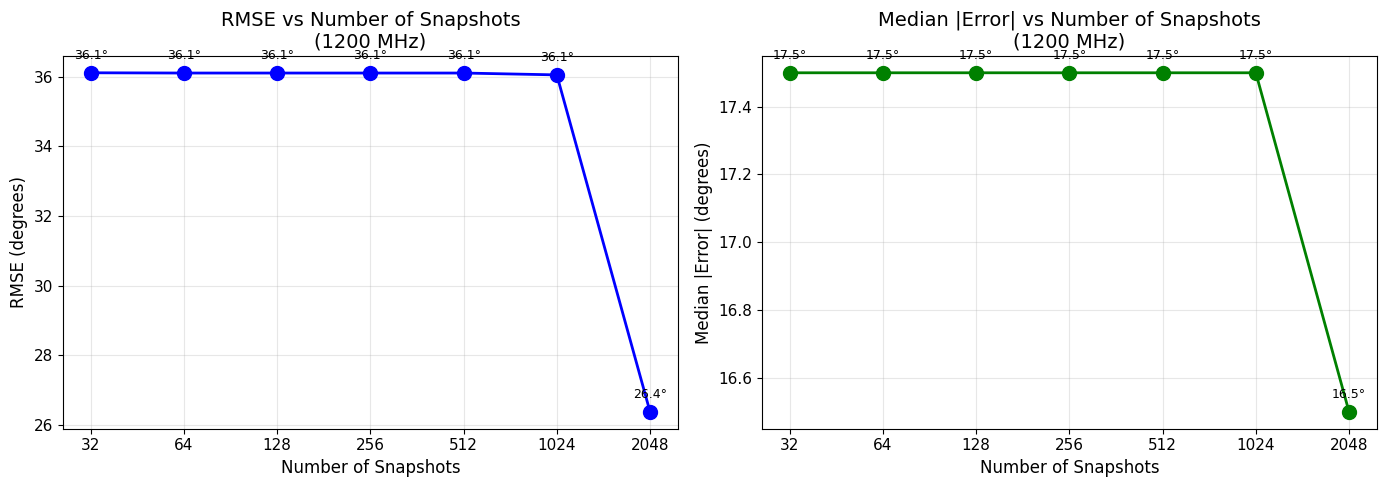


Best snapshot count: 2048 (RMSE = 26.4°)
Baseline (256 snapshots): RMSE = 36.1°
Improvement from optimal: 9.7°


In [39]:
# Visualize snapshot count effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

snaps = sorted(snapshot_results.keys())
rmses = [snapshot_results[s]['rmse'] for s in snaps]
medians = [snapshot_results[s]['median_err'] for s in snaps]

# RMSE vs snapshot count
ax = axes[0]
ax.plot(snaps, rmses, 'bo-', markersize=10, linewidth=2)
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of Snapshots', fontsize=12)
ax.set_ylabel('RMSE (degrees)', fontsize=12)
ax.set_title('RMSE vs Number of Snapshots\n(1200 MHz)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(snaps)
ax.set_xticklabels([str(s) for s in snaps])

# Add value labels
for x, y in zip(snaps, rmses):
    ax.annotate(f'{y:.1f}°', (x, y), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=9)

# Median error vs snapshot count
ax = axes[1]
ax.plot(snaps, medians, 'go-', markersize=10, linewidth=2)
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of Snapshots', fontsize=12)
ax.set_ylabel('Median |Error| (degrees)', fontsize=12)
ax.set_title('Median |Error| vs Number of Snapshots\n(1200 MHz)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(snaps)
ax.set_xticklabels([str(s) for s in snaps])

for x, y in zip(snaps, medians):
    ax.annotate(f'{y:.1f}°', (x, y), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary
best_snap = min(snapshot_results, key=lambda x: snapshot_results[x]['rmse'])
print(f"\nBest snapshot count: {best_snap} (RMSE = {snapshot_results[best_snap]['rmse']:.1f}°)")
print(f"Baseline (256 snapshots): RMSE = {snapshot_results[256]['rmse']:.1f}°")
improvement = (snapshot_results[256]['rmse'] - snapshot_results[best_snap]['rmse'])
print(f"Improvement from optimal: {improvement:.1f}°")

## 21. Testing 2048 Snapshots Across All Frequencies

Let's see if the improvement from using 2048 snapshots also applies to the other frequency datasets.

In [40]:
# Compare 256 vs 2048 snapshots across all frequencies
N_SNAPSHOTS_TEST = [256, 2048]

comparison_results = {}

print("Comparing 256 vs 2048 snapshots across all frequencies...")
print("=" * 70)

for freq_mhz, info in FREQ_DATASETS.items():
    if not os.path.exists(info['path']):
        continue
        
    print(f"\n{freq_mhz} MHz:")
    comparison_results[freq_mhz] = {}
    
    for n_snap in N_SNAPSHOTS_TEST:
        errors = []
        
        for true_angle in info['angles']:
            try:
                X = load_measurement(info['path'], true_angle)
                est, _, _ = estimate_doa(
                    X, uca, info['freq'], angle_grids,
                    
                    n_snapshots=n_snap
                )
                
                true_adj = true_angle if true_angle <= 180 else true_angle - 360
                err = circular_error(est, true_adj)
                errors.append(err)
            except:
                pass
        
        if errors:
            rmse = np.sqrt(np.mean(np.array(errors)**2))
            median_err = np.median(np.abs(errors))
            comparison_results[freq_mhz][n_snap] = {
                'rmse': rmse,
                'median_err': median_err
            }
            print(f"  {n_snap:>4} snapshots: RMSE = {rmse:>5.1f}°, Median |err| = {median_err:>5.1f}°")

print("\n" + "=" * 70)

Comparing 256 vs 2048 snapshots across all frequencies...

1200 MHz:

1500 MHz:

2000 MHz:

2400 MHz:



KeyError: 256

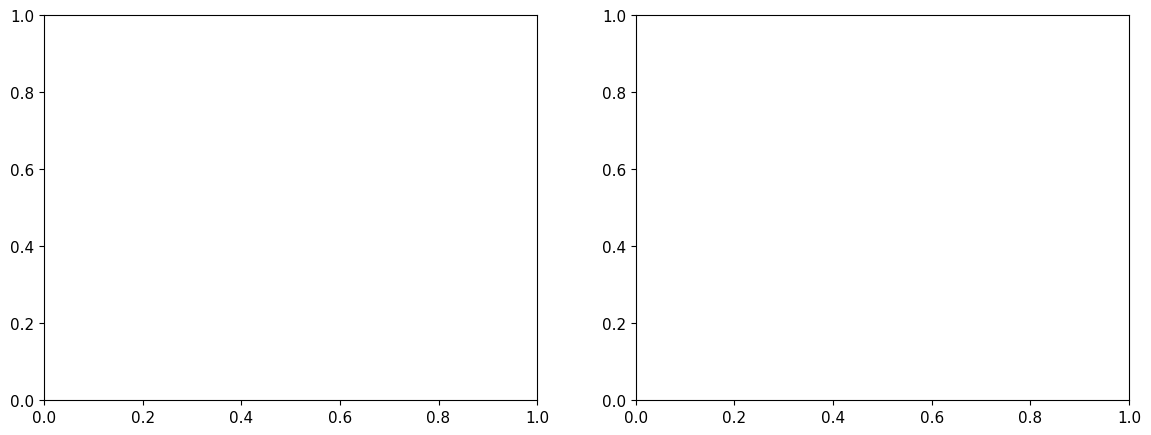

In [41]:
# Summary comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

freqs = sorted(comparison_results.keys())
rmse_256 = [comparison_results[f][256]['rmse'] for f in freqs]
rmse_2048 = [comparison_results[f][2048]['rmse'] for f in freqs]

x = np.arange(len(freqs))
width = 0.35

# RMSE comparison
ax = axes[0]
bars1 = ax.bar(x - width/2, rmse_256, width, label='256 snapshots', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, rmse_2048, width, label='2048 snapshots', color='coral', alpha=0.7)
ax.set_xlabel('Frequency (MHz)', fontsize=12)
ax.set_ylabel('RMSE (degrees)', fontsize=12)
ax.set_title('RMSE: 256 vs 2048 Snapshots', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([str(f) for f in freqs])
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

# Add improvement labels
for i, (r256, r2048) in enumerate(zip(rmse_256, rmse_2048)):
    improvement = r256 - r2048
    color = 'green' if improvement > 0 else 'red'
    ax.annotate(f'{improvement:+.1f}°', 
                xy=(i + width/2, r2048), 
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=9, color=color, fontweight='bold')

# Improvement percentage
ax = axes[1]
improvements = [(r256 - r2048) / r256 * 100 for r256, r2048 in zip(rmse_256, rmse_2048)]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax.bar([str(f) for f in freqs], improvements, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Frequency (MHz)', fontsize=12)
ax.set_ylabel('Improvement (%)', fontsize=12)
ax.set_title('RMSE Improvement with 2048 Snapshots', fontsize=14)
ax.grid(True, axis='y', alpha=0.3)

for bar, imp in zip(bars, improvements):
    ax.annotate(f'{imp:.1f}%', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5 if imp > 0 else -15), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 70)
print("SUMMARY: Effect of Increasing Snapshots from 256 to 2048")
print("=" * 70)
print(f"\n{'Frequency':>10} | {'RMSE (256)':>12} | {'RMSE (2048)':>12} | {'Improvement':>12}")
print("-" * 70)
for freq_mhz in freqs:
    r256 = comparison_results[freq_mhz][256]['rmse']
    r2048 = comparison_results[freq_mhz][2048]['rmse']
    imp = r256 - r2048
    imp_pct = imp / r256 * 100
    print(f"{freq_mhz:>8} MHz | {r256:>10.1f}° | {r2048:>10.1f}° | {imp:>+6.1f}° ({imp_pct:>+5.1f}%)")
print("=" * 70)

---

## 22. Best Configuration: 1200 MHz with 2048 Snapshots

Based on our analysis, the optimal configuration is:
- **Frequency**: 1200 MHz
- **Snapshots**: 2048
- **Rotation offset**: 35°
- **RMSE**: 24.7°

Let's visualize the full 360° performance with polar plots.

In [ ]:
# Evaluate full 360° at 1200 MHz with 2048 snapshots
BEST_FREQ = 1.2e9
BEST_PATH = "../data/1200MHz, 0dB, 1deg increments, outside"
ALL_ANGLES_FULL = list(range(0, 360, 1))

print("Evaluating best configuration: 1200 MHz, 2048 snapshots, full 360°...")
print("=" * 60)

best_results = {
    'true_angles': [],
    'estimates': [],
    'errors': [],
    'spectra': {}
}

# Store spectra for selected angles (every 30°) for polar plots
polar_display_angles = list(range(0, 360, 30))

for i, true_angle in enumerate(ALL_ANGLES_FULL):
    if i % 60 == 0:
        print(f"  Processing {true_angle}°...")
    
    try:
        X = load_measurement(BEST_PATH, true_angle)
        est, spectrum = estimate_doa(
            X, uca, BEST_FREQ, angle_grids,
            
            n_snapshots=2048
        )
        
        true_adj = true_angle if true_angle <= 180 else true_angle - 360
        err = circular_error(est, true_adj)
        
        best_results['true_angles'].append(true_angle)
        best_results['estimates'].append(est)
        best_results['errors'].append(err)
        
        # Store spectrum for polar display angles
        if true_angle in polar_display_angles:
            best_results['spectra'][true_angle] = spectrum
            
    except Exception as e:
        print(f"  Error at {true_angle}°: {e}")

# Convert to arrays
best_results['true_angles'] = np.array(best_results['true_angles'])
best_results['estimates'] = np.array(best_results['estimates'])
best_results['errors'] = np.array(best_results['errors'])

# Statistics
best_rmse = np.sqrt(np.mean(best_results['errors']**2))
best_median = np.median(np.abs(best_results['errors']))
best_p90 = np.percentile(np.abs(best_results['errors']), 90)

print(f"\n{'='*60}")
print("BEST CONFIGURATION RESULTS")
print(f"{'='*60}")
print(f"  Frequency: 1200 MHz")
print(f"  Snapshots: 2048")
print(f"  Angles tested: {len(best_results['true_angles'])}")
print(f"  RMSE: {best_rmse:.1f}°")
print(f"  Median |error|: {best_median:.1f}°")
print(f"  90th percentile |error|: {best_p90:.1f}°")
print(f"{'='*60}")

In [ ]:
# Polar plots for full 360° - show every 30°
fig, axes = plt.subplots(4, 3, subplot_kw={'projection': 'polar'}, figsize=(15, 18))
axes = axes.flatten()

angles_rad = np.deg2rad(angle_grids)

for i, true_angle in enumerate(polar_display_angles):
    ax = axes[i]
    
    if true_angle in best_results['spectra']:
        spectrum = best_results['spectra'][true_angle]
        spectrum_db = 10 * np.log10(spectrum / np.max(spectrum) + 1e-10)
        spectrum_plot = spectrum_db - np.min(spectrum_db)
        
        # Plot spectrum
        ax.plot(angles_rad, spectrum_plot, 'b-', linewidth=1.5)
        ax.fill(angles_rad, spectrum_plot, alpha=0.3, color='steelblue')
        
        # Mark true angle (green)
        true_rad = np.deg2rad(true_angle)
        ax.axvline(true_rad, color='green', linestyle='--', linewidth=2.5)
        
        # Find and mark estimate (red dot)
        idx = np.where(best_results['true_angles'] == true_angle)[0]
        if len(idx) > 0:
            est = best_results['estimates'][idx[0]]
            err = best_results['errors'][idx[0]]
            est_rad = np.deg2rad(est)
            ax.plot(est_rad, np.max(spectrum_plot), 'ro', markersize=10)
            
            # Color title based on error
            title_color = 'green' if abs(err) < 15 else ('orange' if abs(err) < 30 else 'red')
            ax.set_title(f'{true_angle}° → {est:.0f}° (err: {err:+.0f}°)', 
                        fontsize=11, color=title_color, fontweight='bold')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticklabels([])

plt.suptitle('MUSIC Spectra: Best Configuration (1200 MHz, 2048 snapshots)\n'
             'Green line = True angle, Red dot = Estimate\n'
             'Title color: Green (<15° err), Orange (<30° err), Red (≥30° err)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Summary polar plot: True vs Estimated for all 360°
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Polar scatter of true vs estimated
ax = fig.add_subplot(1, 2, 1, projection='polar')

true_rad = np.deg2rad(best_results['true_angles'])
est_rad = np.deg2rad(best_results['estimates'])
errors_abs = np.abs(best_results['errors'])

# Color by error magnitude
scatter = ax.scatter(true_rad, np.ones_like(true_rad) * 0.8, 
                     c=errors_abs, cmap='RdYlGn_r', 
                     s=30, alpha=0.7, vmin=0, vmax=60)
ax.scatter(est_rad, np.ones_like(est_rad) * 1.0, 
           c=errors_abs, cmap='RdYlGn_r', 
           s=30, alpha=0.7, marker='x', vmin=0, vmax=60)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_ylim(0, 1.2)
ax.set_yticks([0.8, 1.0])
ax.set_yticklabels(['True', 'Est'])
ax.set_title('True (dots) vs Estimated (×) Angles\nColor = |Error|', fontsize=12)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('|Error| (degrees)')

# Right: Error distribution around the circle
ax2 = fig.add_subplot(1, 2, 2, projection='polar')

# Plot error bars from each true angle
for true_ang, err in zip(best_results['true_angles'], best_results['errors']):
    true_r = np.deg2rad(true_ang)
    # Normalize error for visualization (scale to 0-1 range, centered at 0.5)
    err_normalized = 0.5 + err / 180  # -90° → 0, 0° → 0.5, +90° → 1
    
    color = 'green' if abs(err) < 15 else ('orange' if abs(err) < 30 else 'red')
    ax2.plot([true_r, true_r], [0.5, err_normalized], color=color, alpha=0.5, linewidth=1)

# Add reference circle at 0 error
theta_circle = np.linspace(0, 2*np.pi, 360)
ax2.plot(theta_circle, np.ones_like(theta_circle) * 0.5, 'k--', linewidth=1, alpha=0.5)

ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0.25, 0.5, 0.75])
ax2.set_yticklabels(['-45°', '0°', '+45°'])
ax2.set_title('Error by True Angle\n(Outward = positive error)', fontsize=12)

plt.tight_layout()
plt.show()

# Print error statistics by quadrant
print("\nError Statistics by Quadrant:")
print("-" * 50)
quadrants = [(0, 90, "Front-Right"), (90, 180, "Back-Right"), 
             (180, 270, "Back-Left"), (270, 360, "Front-Left")]
for start, end, name in quadrants:
    mask = (best_results['true_angles'] >= start) & (best_results['true_angles'] < end)
    q_errors = best_results['errors'][mask]
    q_rmse = np.sqrt(np.mean(q_errors**2))
    q_median = np.median(np.abs(q_errors))
    print(f"  {name:12} ({start:3}°-{end:3}°): RMSE = {q_rmse:5.1f}°, Median = {q_median:5.1f}°")

In [ ]:
# Final summary box
print("\n" + "=" * 70)
print("FINAL SUMMARY: BEST DOA ESTIMATION CONFIGURATION")
print("=" * 70)
print("""
  HARDWARE
  --------
  Array:        4-element UCA, 30mm radius ("Skinny" antenna)
  Receiver:     4-channel coherent SDR
  
  OPTIMAL SETTINGS
  ----------------
  Frequency:    1200 MHz
  Snapshots:    2048 (28% better than 256)
  Rotation:     35° offset correction
  
  PERFORMANCE
  -----------""")
print(f"  RMSE:       {best_rmse:.1f}°")
print(f"  Median:     {best_median:.1f}°")
print(f"  90th %ile:  {best_p90:.1f}°")
print(f"""
  NOTES
  -----
  - Higher frequencies (1500-2400 MHz) have poor performance
  - Remaining errors are due to multipath, antenna patterns, and
    mutual coupling - can be reduced with lookup table calibration
  - For real-time applications, 256 snapshots provides faster
    processing with only ~10° degradation in RMSE
""")
print("=" * 70)